### **LOAD LIBRARIES**

In [120]:
import pandas as pd
import numpy as np

from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import chain

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import mutual_info_regression, f_regression

from matplotlib_venn import venn2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.svm import SVR
import shap
from collections import Counter

from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, skew, kurtosis

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### **FUNCTION FOR EDA**

In [121]:
def classify_feature(series):
    """Intelligently classify feature types with coercion only when appropriate."""
    # Check for datetime
    if pd.api.types.is_datetime64_any_dtype(series):
        return 'Datetime'

    # Get number of unique non-null values
    n_unique = series.nunique(dropna=True)

    # Raw dtype
    dtype = series.dtype

    # Case 1: If it's already numeric dtype
    if pd.api.types.is_numeric_dtype(series):
        if n_unique == 2:
            return 'Binary (Numeric)'
        elif n_unique < 15:
            return 'Multiclass (Numeric)'
        else:
            return 'Numerical'

    # Case 2: If it's an object or string dtype, check if it can be converted
    elif dtype == 'object' or dtype.name == 'string':
        # Try converting to numeric
        coerced = pd.to_numeric(series, errors='coerce')
        non_na = coerced.notna().sum()
        ratio_numeric = non_na / len(series)

        # If most values (e.g. 90%+) are numeric-looking, treat as numeric
        if ratio_numeric > 0.9:
            if coerced.nunique(dropna=True) == 2:
                return 'Binary (Numeric)'
            elif coerced.nunique(dropna=True) < 15:
                return 'Multiclass (Numeric)'
            else:
                return 'Numerical'

        # Otherwise, treat as categorical
        if n_unique == 2:
            return 'Binary (Categorical)'
        elif n_unique < 15:
            return 'Categorical'
        else:
            return 'High Cardinality Categorical'

    # Default fallback
    else:
        return 'Unknown'


def summarize_feature(series):
    """Generate a summary of key values in the feature."""
    if pd.api.types.is_numeric_dtype(series):
        return f"Mean: {series.mean():.2f}, Median: {series.median():.2f}, Std: {series.std():.2f}"
    elif pd.api.types.is_datetime64_any_dtype(series):
        return f"Min: {series.min()}, Max: {series.max()}"
    else:
        top_categories = series.value_counts(dropna=True).head(3)
        return ', '.join(f"{repr(cat)} ({cnt})" for cat, cnt in top_categories.items())

def generate_enhanced_data_report(df):
    # --------- Dataset Summary ---------
    summary = {
        'Total Rows': df.shape[0],
        'Total Features': df.shape[1],
        'Features with Missing Values': df.isnull().any().sum(),
        'Rows with Missing Values': df.isnull().any(axis=1).sum(),
        'Total Missing Values': df.isnull().sum().sum(),
        'Duplicate Rows': df.duplicated().sum()
    }
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

    # --------- Feature Report ---------
    report_rows = []

    for col in df.columns:
        series = df[col]
        feature_type = classify_feature(series)
        total = len(series)
        missing = series.isnull().sum()
        percent_missing = 100 * missing / total
        n_unique = series.nunique(dropna=True)
        example_values = series.dropna().unique()[:3]

        report_rows.append({
            'Feature': col,
            'Feature Type': feature_type,
            'Data Type':series.dtypes,
            '# Missing': missing,
            '% Missing': f"{percent_missing:.1f}%",
            '# Unique': n_unique,
            'Example Values': ', '.join(map(str, example_values)),
            'Summary Stats': summarize_feature(series)
        })

    feature_report_df = pd.DataFrame(report_rows)

    return summary_df, feature_report_df

### **FUNCTION TO LOAD AND CLEAN DATA**

In [122]:
def load_and_clean_excel(file_path_or_url):
    # Step 1: Load Excel file
    df = pd.read_excel(file_path_or_url, sheet_name="Data")
    print('Loading excel...',df.shape)

    # Step 2: Fix headers if misaligned
    new_columns = []
    for i, col in enumerate(df.columns):
        if ('Unnamed' in col
            or col in [
                'Personality factors',
                'Emotional Likert explicit scores',
                'Workplace / functional Likert explicit scores',
                'Emotional Fast Choice implicit scores',
                'Workplace / functional Fast choice implicit scores'
            ]):
            new_columns.append(df.iloc[0, i])
        else:
            new_columns.append(col)

    df.columns = new_columns
    df = df.drop(index=0).reset_index(drop=True)
    print('Fixed Headers...')

    # Step 3: Generate feature report
    summary, feature_report = generate_enhanced_data_report(df)
    print('Summary of Data',summary)
    display(feature_report)

    # Step 4: Assign proper data types
    for _, row in feature_report.iterrows():
        col = row['Feature']
        ftype = row['Feature Type']

        if ftype in ['Categorical', 'Binary (Categorical)', 'High Cardinality Categorical']:
            df[col] = df[col].astype(str)

        elif ftype == 'Multiclass (Numeric)':
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        elif ftype == 'Numerical':
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    print('Fixed Data Types...')

    # Step 5: Final clean-up
    df_clean = df.dropna().reset_index(drop=True)

    print("✅ Cleaned data shape:", df_clean.shape)
    return df_clean


### **FUNCTION TO ENCODE DATA**

In [123]:
def encode_and_scale(df_clean):
    # 1. Define columns
    categorical_cols = [ 'Gender','Batch Group']
    ordinal_col = 'Age'
    age_order = ['18-24', '25-40', '41-64']  # Make sure this is correct

    # 2. Ensure all are strings before encoding
    df_clean[categorical_cols + [ordinal_col]] = df_clean[categorical_cols + [ordinal_col]].astype('string')

    # 3. Label Encode categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])

        # Print mapping
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"\n📋 Encoding for column '{col}':")
        for k, v in mapping.items():
          print(f"  {k} → {v}")

    # 4. Ordinal Encode 'Age'
    ordinal_encoder = OrdinalEncoder(categories=[age_order])
    df_clean['Age_encoded'] = ordinal_encoder.fit_transform(df_clean[[ordinal_col]]).astype(int)

    # 5. Get updated feature types
    summary, feature_report = generate_enhanced_data_report(df_clean)
    feature_dict = dict(zip(feature_report['Feature'], feature_report['Feature Type']))

    # 6. Standard scale all numerical features
    scaler = StandardScaler()
    for feature_name, feature_type in feature_dict.items():
        if feature_type == 'Numerical':
            df_clean[feature_name] = scaler.fit_transform(df_clean[[feature_name]])

    # 7. Drop original categorical columns (keep only encoded versions)
    df_scaled = df_clean.drop(columns=categorical_cols + [ordinal_col])

    print("✅ Scaled DataFrame shape:", df_scaled.shape)
    return df_scaled, mapping

### **FUNCTION FOR OLS ANALYSIS**

In [124]:
# Lets start with OLS

def concise_regression_summary(train_df, test_df, feature_blocks, target_col='Preparedness levels'):
    print("\n REGRESSION INSIGHT SUMMARY")

    y_train = train_df[target_col]
    y_test = test_df[target_col]

    results = {}

    # Step 1: All features
    all_features = list(chain.from_iterable(
        [y for x, y in feature_blocks.items() if x not in ['target', 'qualitative']]
    ))
    X_train_all = sm.add_constant(train_df[all_features])
    X_test_all = sm.add_constant(test_df[all_features])
    model_all = sm.OLS(y_train, X_train_all).fit()
    y_pred_all = model_all.predict(X_test_all)
    r2_all = r2_score(y_test, y_pred_all)

    print("\n🔹 OLS with All Features:")
    print(f"  - Train R²: {model_all.rsquared:.3f}, Test R²: {r2_all:.3f}, Adj R²: {model_all.rsquared_adj:.3f}")

    # Step 2: Feature block-wise OLS
    block_r2s = {}
    print("\n🔹 OLS by Feature Block:")
    for block, features in feature_blocks.items():
        if block in ['target', 'qualitative']:
            continue
        X_train = sm.add_constant(train_df[features])
        X_test = sm.add_constant(test_df[features])
        model_block = sm.OLS(y_train, X_train).fit()
        y_pred_block = model_block.predict(X_test)
        test_r2 = r2_score(y_test, y_pred_block)
        block_r2s[block] = test_r2
        print(f"  - Block '{block}': Train R² = {model_block.rsquared:.3f}, Test R² = {test_r2:.3f}")
        results[f'block_{block}'] = model_block

    # Step 3: LASSO + OLS on selected features
    selected_feature_blocks = []
    selected_r2s = {}
    print("\n🔹 LASSO + OLS on Selected Features per Block:")
    for block, features in feature_blocks.items():
        if block in ['target', 'qualitative']:
            continue
        X_train_block = train_df[features]
        X_test_block = test_df[features]
        lasso = LassoCV(cv=5, random_state=42).fit(X_train_block, y_train)
        selected_mask = lasso.coef_ != 0
        if any(selected_mask):
            selected_features = X_train_block.columns[selected_mask]
            selected_X_train = sm.add_constant(X_train_block[selected_features])
            selected_X_test = sm.add_constant(X_test_block[selected_features])
            model_sel = sm.OLS(y_train, selected_X_train).fit()
            y_pred_sel = model_sel.predict(selected_X_test)
            test_r2 = r2_score(y_test, y_pred_sel)
            selected_feature_blocks.append(train_df[selected_features])
            selected_r2s[block] = test_r2
            print(f"  - Block '{block}': {len(selected_features)} selected → Test R² = {test_r2:.3f}")
        else:
            print(f"  - Block '{block}': ❌ No features selected")

    # Step 4: Combined selected features
    if selected_feature_blocks:
        df_train_selected_combined = pd.concat(selected_feature_blocks, axis=1)
        df_test_selected_combined = pd.concat([test_df[f.columns] for f in selected_feature_blocks], axis=1)
        X_train_combined = sm.add_constant(df_train_selected_combined)
        X_test_combined = sm.add_constant(df_test_selected_combined)
        model_combined = sm.OLS(y_train, X_train_combined).fit()
        y_pred_combined = model_combined.predict(X_test_combined)
        combined_r2 = r2_score(y_test, y_pred_combined)
        print("\n🔹 Combined Selected Features:")
        print(f"  - Train R²: {model_combined.rsquared:.3f}, Test R²: {combined_r2:.3f}")
        results['combined_selected'] = model_combined
    else:
        print("\n⚠️ No features were selected by LASSO from any block.")

    # Step 5: Comparative insights
    print("\n COMPARATIVE INSIGHTS")
    print(f"• All features gave Test R² = {r2_all:.3f}.")
    for block in block_r2s:
        plain = block_r2s[block]
        sel = selected_r2s.get(block, 0)
        if sel > plain:
            print(f"• Block '{block}': Selection improved Test R² from {plain:.3f} → {sel:.3f}. 🎯")
        else:
            print(f"• Block '{block}': Selection did not improve Test R² ({plain:.3f} vs {sel:.3f}).")

    return results


### **FUNCTION FOR REGRESSION ANALYSIS ON IMPLICIT AND EXPLICIT FEATURES**

In [125]:
def comprehensive_regression_analysis(train_df, test_df, feature_blocks, target_col='Preparedness levels'):

    print("\n COMPREHENSIVE REGRESSION ANALYSIS SUITE (NO DATA LEAKAGE)")
    print("="*70)

    # Separate train and test targets
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    results = {}
    test_results = {}
    diagnostics = {}

    # ===============================================
    # PHASE 1: CORE MODEL BUILDING & COMPARISON
    # ===============================================

    print("\n📊 PHASE 1: MODEL BUILDING & PERFORMANCE")
    print("-" * 50)

    # Define feature groups
    explicit_features = feature_blocks['explicit_emotional'] + feature_blocks['explicit_workplace']
    implicit_features = feature_blocks['implicit_emotional'] + feature_blocks['implicit_workplace']
    all_features = explicit_features + implicit_features

    # Build core models ON TRAINING DATA ONLY
    models_to_build = {
        'explicit_only': explicit_features,
        'implicit_only': implicit_features,
        'combined': all_features
    }

    cv_scores = {}
    test_scores = {}

    for model_name, features in models_to_build.items():
        # Train OLS Model on training data
        X_train = sm.add_constant(train_df[features])
        model = sm.OLS(y_train, X_train).fit()
        results[model_name] = model

        # Cross-validation on TRAINING data only (proper approach)
        lr = LinearRegression()
        cv_score = cross_val_score(lr, train_df[features], y_train, cv=5, scoring='r2')
        cv_scores[model_name] = cv_score

        # Test performance on held-out test set
        X_test = sm.add_constant(test_df[features])
        test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_scores[model_name] = test_r2

        print(f"{model_name.replace('_', ' ').title():<15}: "
              f"Train R²={model.rsquared:.3f}, "
              f"CV R²={cv_score.mean():.3f}±{cv_score.std():.3f}, "
              f"Test R²={test_r2:.3f}")

    # Model comparison metrics (training data)
    print(f"\n📈 Model Information Criteria (Training):")
    for name, model in results.items():
        print(f"{name.replace('_', ' ').title():<15}: AIC={model.aic:.1f}, BIC={model.bic:.1f}")

    # ===============================================
    # PHASE 2: FEATURE SELECTION & OPTIMIZATION
    # ===============================================

    print(f"\n🎯 PHASE 2: LASSO FEATURE SELECTION (Training Data)")
    print("-" * 50)

    selected_features = {}
    lasso_models = {}

    for group_name, features in [('explicit', explicit_features), ('implicit', implicit_features)]:
        # LASSO selection on TRAINING data only
        lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
        lasso.fit(train_df[features], y_train)

        # Get selected features
        selected_mask = lasso.coef_ != 0
        selected = [f for f, sel in zip(features, selected_mask) if sel]
        selected_features[group_name] = selected

        if selected:
            # Build OLS model with selected features on TRAINING data
            X_train_selected = sm.add_constant(train_df[selected])
            model_selected = sm.OLS(y_train, X_train_selected).fit()
            lasso_models[f'{group_name}_lasso'] = model_selected
            results[f'{group_name}_lasso'] = model_selected

            # Test LASSO-selected model on test set
            X_test_selected = sm.add_constant(test_df[selected])
            test_pred_lasso = model_selected.predict(X_test_selected)
            test_r2_lasso = r2_score(y_test, test_pred_lasso)
            test_scores[f'{group_name}_lasso'] = test_r2_lasso

            print(f"{group_name.capitalize():<10}: {len(selected)}/{len(features)} features selected, "
                  f"Train R²={model_selected.rsquared:.3f}, Test R²={test_r2_lasso:.3f}")
        else:
            print(f"{group_name.capitalize():<10}: No features selected by LASSO")

    # ===============================================
    # PHASE 3: INCREMENTAL VALUE & SIGNIFICANCE
    # ===============================================

    print(f"\n💡 PHASE 3: INCREMENTAL VALUE ANALYSIS")
    print("-" * 50)

    # Calculate incremental contributions (training performance)
    r2_explicit_train = results['explicit_only'].rsquared
    r2_implicit_train = results['implicit_only'].rsquared
    r2_combined_train = results['combined'].rsquared

    # Calculate incremental contributions (test performance)
    r2_explicit_test = test_scores['explicit_only']
    r2_implicit_test = test_scores['implicit_only']
    r2_combined_test = test_scores['combined']

    incremental_implicit_train = r2_combined_train - r2_explicit_train
    incremental_explicit_train = r2_combined_train - r2_implicit_train

    incremental_implicit_test = r2_combined_test - r2_explicit_test
    incremental_explicit_test = r2_combined_test - r2_implicit_test

    print("Training Performance:")
    print(f"  Implicit adds over explicit: +{incremental_implicit_train:.3f} R² "
          f"({incremental_implicit_train/r2_explicit_train*100:.1f}% improvement)")
    print(f"  Explicit adds over implicit: +{incremental_explicit_train:.3f} R² "
          f"({incremental_explicit_train/r2_implicit_train*100:.1f}% improvement)")

    print("Test Performance (Unbiased):")
    print(f"  Implicit adds over explicit: +{incremental_implicit_test:.3f} R² "
          f"({incremental_implicit_test/max(r2_explicit_test, 0.001)*100:.1f}% improvement)")
    print(f"  Explicit adds over implicit: +{incremental_explicit_test:.3f} R² "
          f"({incremental_explicit_test/max(r2_implicit_test, 0.001)*100:.1f}% improvement)")

    # Statistical significance test (on training data - this is appropriate)
    n = len(train_df)
    k_implicit = len(implicit_features)
    k_combined = len(all_features)

    rss_explicit = np.sum(results['explicit_only'].resid ** 2)
    rss_combined = np.sum(results['combined'].resid ** 2)

    f_statistic = ((rss_explicit - rss_combined) / k_implicit) / (rss_combined / (n - k_combined - 1))
    p_value = 1 - stats.f.cdf(f_statistic, k_implicit, n - k_combined - 1)

    print(f"\nF-test for implicit features: F={f_statistic:.3f}, p={p_value:.4f}")

    significance_level = "highly significant (***)" if p_value < 0.001 else \
                        "significant (**)" if p_value < 0.01 else \
                        "marginally significant (*)" if p_value < 0.05 else \
                        "not significant"
    print(f"Statistical significance: {significance_level}")

    # ===============================================
    # PHASE 4: CONSTRUCT VALIDITY & CORRELATIONS
    # ===============================================

    print(f"\n🔗 PHASE 4: CONSTRUCT VALIDITY ANALYSIS (Training Data)")
    print("-" * 50)

    # Cross-domain correlations (calculated on training data to avoid leakage)
    cross_correlations = []
    domain_correlations = {'emotional': [], 'workplace': []}

    # Emotional domain
    for exp_feat in feature_blocks['explicit_emotional']:
        for imp_feat in feature_blocks['implicit_emotional']:
            if exp_feat in train_df.columns and imp_feat in train_df.columns:
                corr = train_df[exp_feat].corr(train_df[imp_feat])
                if not np.isnan(corr):
                    cross_correlations.append(abs(corr))
                    domain_correlations['emotional'].append(abs(corr))

    # Workplace domain
    for exp_feat in feature_blocks['explicit_workplace']:
        for imp_feat in feature_blocks['implicit_workplace']:
            if exp_feat in train_df.columns and imp_feat in train_df.columns:
                corr = train_df[exp_feat].corr(train_df[imp_feat])
                if not np.isnan(corr):
                    cross_correlations.append(abs(corr))
                    domain_correlations['workplace'].append(abs(corr))

    avg_cross_corr = np.mean(cross_correlations) if cross_correlations else 0
    avg_emotional_corr = np.mean(domain_correlations['emotional']) if domain_correlations['emotional'] else 0
    avg_workplace_corr = np.mean(domain_correlations['workplace']) if domain_correlations['workplace'] else 0

    print(f"Average cross-correlation (explicit-implicit): {avg_cross_corr:.3f}")
    print(f"  - Emotional domain: {avg_emotional_corr:.3f}")
    print(f"  - Workplace domain: {avg_workplace_corr:.3f}")

    # Construct validity interpretation
    if avg_cross_corr < 0.3:
        validity_msg = "✅ Low correlation - measures capture different constructs (good discriminant validity)"
    elif avg_cross_corr > 0.7:
        validity_msg = "⚠️ High correlation - potential measurement redundancy"
    else:
        validity_msg = "📊 Moderate correlation - partial construct overlap"

    print(f"Construct validity: {validity_msg}")

    # ===============================================
    # PHASE 5: TOP PREDICTIVE FEATURES
    # ===============================================

    print(f"\n🔝 PHASE 5: KEY PREDICTIVE FEATURES (From Training)")
    print("-" * 50)

    # Get top features from LASSO models (trained on training data)
    for group in ['explicit', 'implicit']:
        if f'{group}_lasso' in results:
            coefs = results[f'{group}_lasso'].params.drop('const')
            top_features = coefs.abs().sort_values(ascending=False).head(3)

            print(f"\nTop 3 {group.capitalize()} Features:")
            for i, (feature, coef) in enumerate(top_features.items()):
                direction = "↑" if coef > 0 else "↓"
                print(f"  {i+1}. {feature}: {coef:.3f} {direction}")

    # ===============================================
    # PHASE 6: BUSINESS INSIGHTS & RECOMMENDATIONS
    # ===============================================

    print(f"\n💼 PHASE 6: BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("-" * 50)

    # Base recommendations on TEST performance (unbiased)
    print("📊 UNBIASED TEST SET RESULTS:")
    print(f"  Explicit-only Test R²: {r2_explicit_test:.3f}")
    print(f"  Implicit-only Test R²: {r2_implicit_test:.3f}")
    print(f"  Combined Test R²:      {r2_combined_test:.3f}")

    # Determine superior approach based on test performance
    if r2_implicit_test > r2_explicit_test:
        better_approach = "implicit"
        performance_gap = r2_implicit_test - r2_explicit_test
        print(f"\n🎯 Implicit measures outperform explicit by {performance_gap:.3f} R² points (test set)")
        print("   → Unconscious reactions better predict preparedness than self-reports")
    else:
        better_approach = "explicit"
        performance_gap = r2_explicit_test - r2_implicit_test
        print(f"\n🎯 Explicit measures outperform implicit by {performance_gap:.3f} R² points (test set)")
        print("   → Conscious self-assessment captures key preparedness factors")

    # Combined approach value (test performance)
    combined_improvement_test = r2_combined_test - max(r2_explicit_test, r2_implicit_test)

    if combined_improvement_test > 0.05:
        recommendation = "✅ RECOMMEND: Use both measurement types (substantial added value)"
    elif combined_improvement_test > 0.02:
        recommendation = "📊 CONSIDER: Dual approach (moderate added value vs. cost)"
    else:
        recommendation = f"⚠️ SUFFICIENT: Single approach ({better_approach}) may be adequate"

    print(f"\nCombined approach adds: +{combined_improvement_test:.3f} R² (test set)")
    print(f"Recommendation: {recommendation}")

    # Generalization assessment
    train_test_gap_combined = r2_combined_train - r2_combined_test
    print(f"\n🔍 GENERALIZATION ASSESSMENT:")
    print(f"Train-Test R² gap (combined): {train_test_gap_combined:.3f}")

    if train_test_gap_combined > 0.1:
        generalization_msg = "⚠️ Poor generalization - possible overfitting"
    elif train_test_gap_combined > 0.05:
        generalization_msg = "📊 Moderate generalization gap - monitor performance"
    else:
        generalization_msg = "✅ Good generalization - stable model performance"

    print(f"Generalization: {generalization_msg}")

    # ===============================================
    # COMPILE COMPREHENSIVE RESULTS
    # ===============================================

    comprehensive_metrics = {
        'model_performance': {
            'train_performance': {
                'r2_explicit': r2_explicit_train,
                'r2_implicit': r2_implicit_train,
                'r2_combined': r2_combined_train
            },
            'test_performance': {
                'r2_explicit': r2_explicit_test,
                'r2_implicit': r2_implicit_test,
                'r2_combined': r2_combined_test
            },
            'cv_scores': cv_scores,
            'generalization_gap': train_test_gap_combined
        },
        'incremental_analysis': {
            'train': {
                'incremental_implicit': incremental_implicit_train,
                'incremental_explicit': incremental_explicit_train
            },
            'test': {
                'incremental_implicit': incremental_implicit_test,
                'incremental_explicit': incremental_explicit_test
            },
            'f_statistic': f_statistic,
            'p_value': p_value
        },
        'construct_validity': {
            'avg_cross_correlation': avg_cross_corr,
            'domain_correlations': {
                'emotional': avg_emotional_corr,
                'workplace': avg_workplace_corr
            }
        },
        'feature_selection': {
            'selected_features': selected_features,
            'selection_counts': {k: len(v) for k, v in selected_features.items()}
        },
        'business_insights': {
            'better_approach': better_approach,
            'test_combined_improvement': combined_improvement_test,
            'recommendation': recommendation,
            'generalization_assessment': generalization_msg
        }
    }

    return models_to_build, results, comprehensive_metrics, test_scores

In [126]:


def run_regression_diagnostics(model, X, y, model_name="Model"):
    print(f"\n🧪 REGRESSION DIAGNOSTICS FOR: {model_name}")
    print("=" * 60)

    residuals = model.resid
    fitted_vals = model.fittedvalues

    # RESIDUAL SUMMARY
    mean_resid = np.mean(residuals)
    std_resid = np.std(residuals)
    skew_resid = skew(residuals)
    kurt_resid = kurtosis(residuals, fisher=False)
    shapiro_stat, shapiro_p = shapiro(residuals)
    dw_stat = durbin_watson(residuals)

    print(f"\nRESIDUAL ANALYSIS")
    print("-" * 40)
    print(f"Residual Analysis for {model_name}:")
    print(f"  - Mean residual: {mean_resid:.6f}")
    print(f"  - Std residual: {std_resid:.3f}")
    print(f"  - Skewness: {skew_resid:.3f}")
    print(f"  - Kurtosis: {kurt_resid:.3f}")
    print(f"  - Normality (Shapiro-Wilk): {'✅ Normal' if shapiro_p >= 0.05 else '⚠️ Non-normal'} (p={shapiro_p:.4f})")
    print(f"  - Autocorrelation (Durbin-Watson): {'✅ No autocorrelation' if 1.5 < dw_stat < 2.5 else '⚠️ Possible autocorrelation'} (DW={dw_stat:.3f})")

    # 1. LINEARITY: Residuals vs. Fitted
    plt.figure(figsize=(6, 4))
    sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.axhline(0, linestyle='--', color='grey')
    plt.title(f"{model_name} - Residuals vs Fitted (Linearity)")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # 2. HOMOSCEDASTICITY: Breusch-Pagan test
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_breuschpagan(residuals, model.model.exog)
    print(f"\nHOMOSCEDASTICITY (Breusch-Pagan):")
    print(f"  - LM stat = {lm_stat:.3f}, p = {lm_pvalue:.4f}")
    print(f"  - F stat  = {f_stat:.3f}, p = {f_pvalue:.4f}")
    if f_pvalue < 0.05:
        print("  ⚠️ Heteroscedasticity detected (variance not constant)")
    else:
        print("  ✅ Homoscedasticity assumption holds")

    # 3. NORMALITY: Q-Q plot
    sm.qqplot(residuals, line='s')
    plt.title(f"{model_name} - Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    # 4. MULTICOLLINEARITY: Top 10 VIF
    print(f"\nMULTICOLLINEARITY (Top 10 VIF):")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    top_vif = vif_data.sort_values("VIF", ascending=False).head(10)
    print(top_vif.round(2))

    # 5. INFLUENTIAL POINTS: Cook's Distance
    infl = model.get_influence()
    cooks_d = infl.cooks_distance[0]
    threshold = 4 / len(X)

    plt.figure(figsize=(6, 4))
    plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
    plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.title(f"{model_name} - Cook's Distance (Influential Points)")
    plt.xlabel("Observation Index")
    plt.ylabel("Cook's Distance")
    plt.legend()
    plt.tight_layout()
    plt.show()

    num_influential = sum(cooks_d > threshold)
    print(f"\nINFLUENTIAL POINTS (Cook's Distance):")
    print(f"  - {num_influential} observations exceed threshold (4/n = {threshold:.4f})")


### **MORE PREDICTIVE ANALYSIS ON PREPAREDENESS LEVELS**

In [127]:
#  Clearly features have non linear relations .. lets analyse features a bit more

def feature_informativeness(X, y, top_n=10, plot=True):
    """Compute and rank features, with optional plotting"""

    mi = mutual_info_regression(X, y)
    f_vals, _ = f_regression(X, y)
    pearson_corr = [pearsonr(X[col], y)[0] for col in X.columns]
    spearman_corr = [spearmanr(X[col], y)[0] for col in X.columns]

    info_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Info': mi,
        'F_stat': f_vals,
        'Pearson_corr': pearson_corr,
        'Spearman_corr': spearman_corr
    }).sort_values('Mutual_Info', ascending=False).reset_index(drop=True)

    if plot:
        top_features = info_df.head(top_n)
        plt.figure(figsize=(8, 5))
        sns.barplot(x='Mutual_Info', y='Feature', data=top_features, palette='viridis')
        plt.title(f"Top {top_n} Features by Mutual Information")
        plt.xlabel("Mutual Information Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    return info_df

In [128]:
def incremental_feature_selection(X, y, ranking_df, model=RidgeCV(), scoring='r2', max_features=30):
    results = []
    top_features = ranking_df['Feature'].tolist()

    for k in range(1, min(max_features, len(top_features)) + 1):
        selected = top_features[:k]
        X_sub = X[selected]

        # Cross-validated performance
        scores = cross_val_score(model, X_sub, y, cv=5, scoring=scoring)
        model.fit(X_sub,y)
        y_pred = model.predict(test_df[selected])
        r_sq = r2_score(test_df['Preparedness levels'],y_pred)
        results.append((k, scores.mean(), scores.std(),r_sq))

    results_df = pd.DataFrame(results, columns=['Num_Features', 'Mean_Score', 'Std_Score','Test_R2'])

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(results_df['Num_Features'], results_df['Mean_Score'], marker='o')
    plt.fill_between(results_df['Num_Features'],
                     results_df['Mean_Score'] - results_df['Std_Score'],
                     results_df['Mean_Score'] + results_df['Std_Score'],
                     alpha=0.2)
    plt.title(f'Model Performance vs. Number of Features ({scoring})')
    plt.xlabel("Number of Features")
    plt.ylabel(f"Cross-validated {scoring}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Best number of features
    best_row = results_df.loc[results_df['Mean_Score'].idxmax()]
    k_best = int(best_row.Num_Features)
    best_features = top_features[:k_best]

    print(f"\n🏆 Best performance with {k_best} features: {best_row.Mean_Score:.3f} ± {best_row.Std_Score:.3f}")
    print(f"🧠 Top {k_best} most informative features used:")
    for i, feat in enumerate(best_features, start=1):
        print(f"{i:2d}. {feat}")

    return results_df, best_features

In [129]:
def train_and_evaluate_models(train_df, test_df, target_col, feature_list):
    models = {
        'Ridge': RidgeCV(),
        'Lasso': LassoCV(cv=5),
        'SVR': SVR(kernel='rbf'),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    X_train = train_df[feature_list]
    y_train = train_df[target_col]
    X_test = test_df[feature_list]
    y_test = test_df[target_col]

    results = []
    model_objects = {}
    y_preds = {}

    for name, model in models.items():
        print(f"\n🔍 Training {name}...")
        model.fit(X_train, y_train)

         # Cross-validation on training set
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        cv_mean = np.mean(cv_scores)

        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        bias = np.mean(y_test - y_pred)

        results.append({'Model': name, 'cv_score':cv_mean,'Test_R2': r2, 'RMSE': rmse, 'MAE': mae, 'Bias': bias})
        model_objects[name] = model
        y_preds[name] = y_pred

        # Reliability Plot
        plt.figure(figsize=(5, 5))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f'{name} - Predicted vs Actual')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Residual Plot
        residuals = y_test - y_pred
        plt.figure(figsize=(5, 4))
        sns.histplot(residuals, kde=True)
        plt.axvline(0, color='r', linestyle='--')
        plt.title(f'{name} - Residual Distribution')
        plt.xlabel('Residual')
        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(results).sort_values(by='Test_R2', ascending=False)
    print("\n📊 Model Comparison:")
    display(results_df)

    return results_df, model_objects, y_preds, X_test



In [130]:
def shap_feature_importance(best_model, X_test, feature_names, model_type='tree'):
    print(f"\n🔎 SHAP Analysis for {best_model.__class__.__name__}")

    if model_type == 'tree':
        explainer = shap.TreeExplainer(best_model)
    else:
        explainer = shap.Explainer(best_model, X_test)

    shap_values = explainer(X_test)

    shap.plots.beeswarm(shap_values, max_display=20)
    shap.plots.bar(shap_values, max_display=20)


### **FUNCTION FOR COUNTRY WISE ANALYSIS**

In [131]:
def enhanced_country_level_analysis(train_df, test_df, feature_blocks, selected_features,
                                    target_col='Preparedness levels', country_col='Batch Group_encoded'):
    print("\n🌍 ENHANCED COUNTRY-LEVEL ANALYSIS")
    print("="*60)

    # Check unique countries
    countries = train_df[country_col].unique()
    print(f"📍 Found {len(countries)} countries/regions: {countries}")

    # Determine feature types
    explicit_features = feature_blocks['explicit_emotional'] + feature_blocks['explicit_workplace']
    implicit_features = feature_blocks['implicit_emotional'] + feature_blocks['implicit_workplace']

    print(f"\n🔍 Feature Summary:")
    print(f"  - Selected features: {len(selected_features)}")
    print(f"  - Explicit features: {len([f for f in selected_features if f in explicit_features])}")
    print(f"  - Implicit features: {len([f for f in selected_features if f in implicit_features])}")

    # PHASE 1: Individual Country Modeling
    print(f"\n📊 PHASE 1: INDIVIDUAL COUNTRY MODELING")
    print("-" * 50)

    country_results = {}
    country_performance = {}
    country_sample_sizes = {}
    country_feature_importance = {}

    models = {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1, max_iter=2000),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    for country in countries:
        train_country = train_df[train_df[country_col] == country].copy()
        test_country = test_df[test_df[country_col] == country].copy()
        train_size = len(train_country)
        test_size = len(test_country)
        total_size = train_size + test_size
        country_sample_sizes[country] = total_size

        print(f"\n🏴 Country {country}: {total_size} samples (Train: {train_size}, Test: {test_size})")

        if train_size >= 30 and test_size >= 20:
            try:
                X_train = train_country[selected_features]
                y_train = train_country[target_col]
                X_test = test_country[selected_features]
                y_test = test_country[target_col]

                country_model_results = {}

                for model_name, model in models.items():
                    model.fit(X_train, y_train)

                    train_pred = model.predict(X_train)
                    test_pred = model.predict(X_test)

                    train_r2 = r2_score(y_train, train_pred)
                    test_r2 = r2_score(y_test, test_pred)
                    generalization_gap = train_r2 - test_r2

                    full_data = pd.concat([X_train, X_test])
                    full_target = pd.concat([y_train, y_test])

                    cv_scores = cross_val_score(model, full_data, full_target, cv=5, scoring='r2')
                    cv_mean = cv_scores.mean()
                    cv_std = cv_scores.std()

                    country_model_results[model_name] = {
                        'train_r2': train_r2,
                        'test_r2': test_r2,
                        'generalization_gap': generalization_gap,
                        'cv_mean': cv_mean,
                        'cv_std': cv_std,
                        'model': model
                    }

                best_model_name = max(country_model_results, key=lambda x: country_model_results[x]['cv_mean'])
                best_model_info = country_model_results[best_model_name]
                best_model = best_model_info['model']

                if hasattr(best_model, 'feature_importances_'):
                    importance_scores = best_model.feature_importances_
                elif hasattr(best_model, 'coef_'):
                    importance_scores = np.abs(best_model.coef_)
                else:
                    importance_scores = np.zeros(len(selected_features))

                feature_importance = pd.DataFrame({
                    'feature': selected_features,
                    'importance': importance_scores
                }).sort_values('importance', ascending=False)

                country_results[country] = {
                    'best_model': best_model_name,
                    'model_results': country_model_results,
                    'feature_importance': feature_importance,
                    'sample_size': total_size
                }

                country_performance[country] = {
                    'best_model': best_model_name,
                    'train_r2': best_model_info['train_r2'],
                    'test_r2': best_model_info['test_r2'],
                    'cv_mean': best_model_info['cv_mean'],
                    'cv_std': best_model_info['cv_std'],
                    'generalization_gap': best_model_info['generalization_gap'],
                    'sample_size': total_size
                }

                country_feature_importance[country] = feature_importance.head(10)

                print(f"   ✅ Best Model: {best_model_name}")
                print(f"   📊 Test R² = {best_model_info['test_r2']:.3f}, CV = {best_model_info['cv_mean']:.3f}±{best_model_info['cv_std']:.3f}")
                print(f"   🎯 Top 3 Features: {', '.join(feature_importance.head(3)['feature'])}")

            except Exception as e:
                print(f"   ❌ Error fitting model: {str(e)}")
        else:
            print(f"   ⚠️  Insufficient train/test size (min 30 train & 20 test)")

    if country_performance:
        print(f"\n📊 COUNTRY MODEL PERFORMANCE COMPARISON:")
        performance_df = pd.DataFrame(country_performance).T
        performance_df = performance_df.sort_values('test_r2', ascending=False)
        print(performance_df[['best_model', 'test_r2', 'cv_mean', 'generalization_gap', 'sample_size']].to_string())

    # PHASE 2: Clustering
    print(f"\n🔗 PHASE 2: COUNTRY CLUSTERING ANALYSIS")
    print("-" * 50)

    if len(country_feature_importance) >= 3:
        clustering_matrix = []
        clustering_countries = []

        for country, importance_df in country_feature_importance.items():
            top_10 = importance_df.head(10)['importance'].values
            top_10 = np.pad(top_10, (0, 10 - len(top_10)))
            clustering_matrix.append(top_10)
            clustering_countries.append(country)

        clustering_matrix = np.array(clustering_matrix)
        n_clusters = min(4, max(2, len(clustering_countries) // 2))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(clustering_matrix)

        clusters = {}
        for i, country in enumerate(clustering_countries):
            cluster_id = cluster_labels[i]
            clusters.setdefault(cluster_id, []).append(country)

        cluster_profiles = {}
        print(f"🎯 COUNTRY CLUSTERS (K={n_clusters}):")
        for cluster_id, countries_in_cluster in clusters.items():
            # print(f"Cluster {cluster_id + 1}: {', '.join(countries_in_cluster)}")
            print(f"Cluster {cluster_id + 1}: {', '.join(str(c) for c in countries_in_cluster)}")

            features, performances = [], []
            for country in countries_in_cluster:
                features += country_feature_importance[country].head(3)['feature'].tolist()
                performances.append(country_performance[country]['test_r2'])

            feature_counts = Counter(features)
            common_features = [feat for feat, _ in feature_counts.most_common(3)]

            cluster_profiles[cluster_id] = {
                'countries': countries_in_cluster,
                'common_features': common_features,
                'avg_performance': np.mean(performances),
                'performance_std': np.std(performances)
            }

        print(f"\n📈 CLUSTER CHARACTERISTICS:")
        for cid, profile in cluster_profiles.items():
            print(f"Cluster {cid + 1}:")
            print(f"  Countries: {', '.join(str(c) for c in profile['countries'])}")
            # print(f"  Countries: {', '.join(profile['countries'])}")
            print(f"  Key Features: {', '.join(profile['common_features'])}")
            print(f"  Avg Performance: {profile['avg_performance']:.3f}")
            if profile['performance_std'] > 0:
                print(f"  Performance Std: {profile['performance_std']:.3f}")

    # PHASE 3: Implicit vs Explicit
    print(f"\n🎭 PHASE 3: IMPLICIT VS EXPLICIT ANALYSIS BY COUNTRY")
    print("-" * 50)

    implicit_explicit_analysis = {}
    implicit_dominant_countries = []
    explicit_dominant_countries = []

    for country, importance_df in country_feature_importance.items():
        total_importance = importance_df['importance'].sum()
        implicit_importance = importance_df[importance_df['feature'].isin(implicit_features)]['importance'].sum()
        explicit_importance = importance_df[importance_df['feature'].isin(explicit_features)]['importance'].sum()

        if total_importance > 0:
            implicit_pct = (implicit_importance / total_importance) * 100
            explicit_pct = (explicit_importance / total_importance) * 100
        else:
            implicit_pct = explicit_pct = 0

        implicit_explicit_analysis[country] = {
            'explicit_pct': explicit_pct,
            'implicit_pct': implicit_pct,
            'explicit_importance': explicit_importance,
            'implicit_importance': implicit_importance,
            'total_importance': total_importance
        }

        if implicit_pct > explicit_pct:
            implicit_dominant_countries.append((country, implicit_pct))
        else:
            explicit_dominant_countries.append((country, explicit_pct))

    print(f"🔮 IMPLICIT-DOMINANT COUNTRIES ({len(implicit_dominant_countries)}):")
    for country, pct in sorted(implicit_dominant_countries, key=lambda x: x[1], reverse=True):
        print(f"  {country}: {pct:.1f}% implicit")

    print(f"\n📋 EXPLICIT-DOMINANT COUNTRIES ({len(explicit_dominant_countries)}):")
    for country, pct in sorted(explicit_dominant_countries, key=lambda x: x[1], reverse=True):
        print(f"  {country}: {pct:.1f}% explicit")

    # PHASE 4: Cross-Country Consistency
    print(f"\n🌐 PHASE 4: CROSS-COUNTRY FEATURE CONSISTENCY")
    print("-" * 50)

    all_features_across_countries = []
    for importance_df in country_feature_importance.values():
        all_features_across_countries += importance_df.head(5)['feature'].tolist()

    feature_frequency = Counter(all_features_across_countries)
    consistent_features = feature_frequency.most_common(10)

    print("🎯 MOST CONSISTENT FEATURES:")
    for feature, count in consistent_features:
        pct = (count / len(country_feature_importance)) * 100
        print(f"  {feature:40} | {count} countries ({pct:.1f}%)")

    # PHASE 5: Recommendations
    print(f"\n💡 PHASE 5: COUNTRY-SPECIFIC RECOMMENDATIONS")
    print("-" * 50)

    recommendations = {}
    for country in countries:
        if country in country_performance:
            recs = []
            perf = country_performance[country]
            imp = implicit_explicit_analysis[country]

            # Performance recommendations
            if perf['test_r2'] >= 0.8:
                recs.append("✅ High predictive accuracy")
            elif perf['test_r2'] >= 0.6:
                recs.append("📊 Moderate accuracy – consider feature engineering")
            else:
                recs.append("⚠️ Low accuracy – model improvements needed")

            if perf['generalization_gap'] < 0.05:
                recs.append("✅ Good generalization")
            else:
                recs.append("⚠️ Overfitting risk – try regularization")

            if imp['explicit_pct'] > 70:
                recs.append("📋 Emphasize explicit indicators")
            elif imp['implicit_pct'] > 70:
                recs.append("🔮 Emphasize implicit indicators")
            else:
                recs.append("⚖️ Balanced implicit-explicit strategy")

            recommendations[country] = recs
            print(f"\n🏴 {country}:")
            for r in recs:
                print(f"  {r}")

    return {
        'country_performance': country_performance,
        'country_results': country_results,
        'country_feature_importance': country_feature_importance,
        'cluster_profiles': cluster_profiles if 'cluster_profiles' in locals() else {},
        'implicit_explicit_analysis': implicit_explicit_analysis,
        'implicit_dominant_countries': implicit_dominant_countries,
        'explicit_dominant_countries': explicit_dominant_countries,
        'consistent_features': consistent_features,
        'country_sample_sizes': country_sample_sizes,
        'recommendations': recommendations
    }


In [132]:
def plot_country_clusters(enhanced_results):

    # Extract data from results
    cluster_profiles = enhanced_results.get('cluster_profiles', {})
    country_feature_importance = enhanced_results.get('country_feature_importance', {})
    country_performance = enhanced_results.get('country_performance', {})

    if not cluster_profiles or not country_feature_importance:
        print("⚠️ No cluster data available for plotting")
        return

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # ==========================================
    # PLOT 1: Country Clusters in 2D PCA Space
    # ==========================================
    ax1 = plt.subplot(2, 3, 1)

    # Prepare clustering data for PCA
    clustering_data = []
    clustering_countries = []
    cluster_labels = []

    for cluster_id, profile in cluster_profiles.items():
        for country in profile['countries']:
            if country in country_feature_importance:
                # Use top 10 feature importances
                importance_values = country_feature_importance[country].head(10)['importance'].values
                if len(importance_values) < 10:
                    importance_values = np.pad(importance_values, (0, 10 - len(importance_values)))

                clustering_data.append(importance_values)
                clustering_countries.append(country)
                cluster_labels.append(cluster_id)

    if len(clustering_data) >= 2:
        # PCA for visualization
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(clustering_data)

        # Create scatter plot
        colors = plt.cm.Set1(np.linspace(0, 1, len(cluster_profiles)))
        for i, (cluster_id, profile) in enumerate(cluster_profiles.items()):
            cluster_mask = [label == cluster_id for label in cluster_labels]
            cluster_pca = pca_data[cluster_mask]
            cluster_countries_filtered = [country for j, country in enumerate(clustering_countries) if cluster_mask[j]]

            ax1.scatter(cluster_pca[:, 0], cluster_pca[:, 1],
                       c=[colors[i]], label=f'Cluster {cluster_id + 1}',
                       s=100, alpha=0.7, edgecolors='black')

            # Add country labels
            for j, (x, y) in enumerate(cluster_pca):
                ax1.annotate(cluster_countries_filtered[j], (x, y),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax1.set_title('Country Clusters (PCA Space)', fontsize=12, fontweight='bold')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ==========================================
    # PLOT 2: Cluster Performance Comparison
    # ==========================================
    ax2 = plt.subplot(2, 3, 2)

    cluster_perf_data = []
    cluster_names = []

    for cluster_id, profile in cluster_profiles.items():
        cluster_names.append(f'Cluster {cluster_id + 1}')
        cluster_perf_data.append(profile['avg_performance'])

    bars = ax2.bar(cluster_names, cluster_perf_data,
                   color=['lightblue', 'lightcoral', 'lightgreen', 'gold'][:len(cluster_names)],
                   alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for bar, value in zip(bars, cluster_perf_data):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax2.set_title('Average Model Performance by Cluster', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score')
    ax2.set_ylim(0, max(cluster_perf_data) * 1.2 if cluster_perf_data else 1)
    ax2.grid(True, alpha=0.3, axis='y')

In [133]:
def c_heatmap(enhanced_results, c_mapping=None):

    # Extract data from results
    cluster_profiles = enhanced_results.get('cluster_profiles', {})
    country_feature_importance = enhanced_results.get('country_feature_importance', {})

    if not cluster_profiles or not country_feature_importance:
        print("⚠️ No cluster data available for plotting")
        return

    # Create figure with enhanced layout
    fig = plt.figure(figsize=(20, 12))


    # ==========================================
    # PLOT 3: Cluster Characteristics Heatmap
    # ==========================================
    ax3 = plt.subplot(2, 3, 4)

    # Create feature importance matrix for clusters
    all_features = set()
    for cluster_id, profile in cluster_profiles.items():
        all_features.update(profile.get('common_features', []))

    if all_features:
        all_features = list(all_features)
        feature_matrix = np.zeros((len(cluster_profiles), len(all_features)))

        for i, (cluster_id, profile) in enumerate(cluster_profiles.items()):
            common_features = profile.get('common_features', [])
            for j, feature in enumerate(all_features):
                if feature in common_features:
                    feature_matrix[i, j] = 1

        # Create heatmap
        im = ax3.imshow(feature_matrix, cmap='RdYlBu_r', aspect='auto', alpha=0.8)

        # Set ticks and labels
        ax3.set_xticks(range(len(all_features)))
        ax3.set_xticklabels([feat[:15] + '...' if len(feat) > 15 else feat
                            for feat in all_features], rotation=45, ha='right')
        ax3.set_yticks(range(len(cluster_profiles)))
        ax3.set_yticklabels([f'Cluster {i+1}' for i in cluster_profiles.keys()])

        # Add text annotations
        for i in range(len(cluster_profiles)):
            for j in range(len(all_features)):
                text = '✓' if feature_matrix[i, j] == 1 else ''
                ax3.text(j, i, text, ha="center", va="center",
                        fontsize=12, fontweight='bold', color='white')

    ax3.set_title('Key Features by Cluster', fontsize=12, fontweight='bold')

### **FUNCTION FOR SEGMENTATION**

In [134]:
# ============================================================================
# STEP 4: ADVANCED SEGMENTATION ANALYSIS
# ============================================================================

def advanced_segmentation_analysis(df_scaled, feature_blocks, target_col='Preparedness levels'):
    """
    Perform comprehensive segmentation analysis using multiple methods
    """
    print("\n👥 ADVANCED SEGMENTATION ANALYSIS")
    print("="*50)

    # Select features for clustering (exclude demographics and target)
    clustering_features = []
    for block_name, features in feature_blocks.items():
        if block_name in ['personality_traits', 'explicit_emotional', 'implicit_emotional',
                         'explicit_workplace', 'implicit_workplace']:
            clustering_features.extend(features)

    print(f"🎯 Using {len(clustering_features)} features for clustering")

    X_cluster = df_scaled[clustering_features]

    # -----------------------------------------------------------------------
    # METHOD 1: K-Means with Optimal Cluster Selection
    # -----------------------------------------------------------------------

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import matplotlib.pyplot as plt

    print("\n🔍 K-MEANS CLUSTERING ANALYSIS:")

    # Test different numbers of clusters
    k_range = range(2, 8)
    silhouette_scores = []
    inertia_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_cluster)
        silhouette_avg = silhouette_score(X_cluster, cluster_labels)

        silhouette_scores.append(silhouette_avg)
        inertia_scores.append(kmeans.inertia_)

        print(f"  K={k}: Silhouette Score = {silhouette_avg:.3f}, Inertia = {kmeans.inertia_:.0f}")

    # Select optimal K
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"🏆 Optimal K selected: {optimal_k} (highest silhouette score)")

    # Final K-means clustering
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = final_kmeans.fit_predict(X_cluster)

    # -----------------------------------------------------------------------
    # METHOD 2: Gaussian Mixture Model
    # -----------------------------------------------------------------------

    from sklearn.mixture import GaussianMixture

    print("\n🔍 GAUSSIAN MIXTURE MODEL ANALYSIS:")

    bic_scores = []
    aic_scores = []

    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X_cluster)

        bic_scores.append(gmm.bic(X_cluster))
        aic_scores.append(gmm.aic(X_cluster))

        print(f"  K={k}: BIC = {gmm.bic(X_cluster):.0f}, AIC = {gmm.aic(X_cluster):.0f}")

    # Select optimal K (lowest BIC)
    optimal_k_gmm = k_range[np.argmin(bic_scores)]
    print(f"🏆 Optimal K for GMM: {optimal_k_gmm} (lowest BIC)")

    # Final GMM clustering
    final_gmm = GaussianMixture(n_components=optimal_k_gmm, random_state=42)
    gmm_labels = final_gmm.fit_predict(X_cluster)

    # -----------------------------------------------------------------------
    # SEGMENT PROFILING
    # -----------------------------------------------------------------------

    def profile_segments(cluster_labels, method_name):
        print(f"\n📊 {method_name} SEGMENT PROFILES:")

        df_with_clusters = df_scaled.copy()
        df_with_clusters['cluster'] = cluster_labels

        segment_profiles = {}

        for cluster_id in np.unique(cluster_labels):
            cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]

            profile = {
                'size': len(cluster_data),
                'percentage': len(cluster_data) / len(df_with_clusters) * 100,
                'preparedness_mean': cluster_data[target_col].mean(),
                'preparedness_std': cluster_data[target_col].std(),
            }

            # Calculate means for each feature block
            for block_name, features in feature_blocks.items():
                if block_name not in ['target', 'qualitative'] and features:
                    available_features = [f for f in features if f in cluster_data.columns]
                    if available_features:
                        profile[f'{block_name}_mean'] = cluster_data[available_features].mean().mean()

            segment_profiles[f'Segment_{cluster_id}'] = profile

            print(f"\n🏷️  Segment {cluster_id}:")
            print(f"   Size: {profile['size']} ({profile['percentage']:.1f}%)")
            print(f"   Preparedness: {profile['preparedness_mean']:.3f} ± {profile['preparedness_std']:.3f}")

            # Show distinguishing characteristics
            cluster_means = cluster_data[clustering_features].mean()
            overall_means = df_scaled[clustering_features].mean()
            differences = cluster_means - overall_means

            # Top 5 distinguishing features
            top_diffs = differences.abs().nlargest(5)
            print("   Top distinguishing features:")
            for feat in top_diffs.index:
                diff = differences[feat]
                direction = "higher" if diff > 0 else "lower"
                print(f"     {feat[:35]:35} | {direction:6} by {abs(diff):.3f}")

        return segment_profiles

    # Profile both clustering methods
    kmeans_profiles = profile_segments(kmeans_labels, "K-MEANS")
    gmm_profiles = profile_segments(gmm_labels, "GAUSSIAN MIXTURE")

    # -----------------------------------------------------------------------
    # STATISTICAL VALIDATION
    # -----------------------------------------------------------------------

    from scipy import stats

    def validate_segments(cluster_labels, method_name):
        print(f"\n🔬 STATISTICAL VALIDATION - {method_name}:")

        df_with_clusters = df_scaled.copy()
        df_with_clusters['cluster'] = cluster_labels

        # ANOVA test for preparedness differences
        groups = [df_with_clusters[df_with_clusters['cluster'] == i][target_col]
                 for i in np.unique(cluster_labels)]

        f_stat, p_value = stats.f_oneway(*groups)
        print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("✅ Segments have significantly different preparedness levels")
        else:
            print("❌ No significant differences between segments")

        return f_stat, p_value

    kmeans_f, kmeans_p = validate_segments(kmeans_labels, "K-MEANS")
    gmm_f, gmm_p = validate_segments(gmm_labels, "GMM")

    return {
        'kmeans': {
            'labels': kmeans_labels,
            'profiles': kmeans_profiles,
            'optimal_k': optimal_k,
            'silhouette_scores': silhouette_scores,
            'f_stat': kmeans_f,
            'p_value': kmeans_p
        },
        'gmm': {
            'labels': gmm_labels,
            'profiles': gmm_profiles,
            'optimal_k': optimal_k_gmm,
            'bic_scores': bic_scores,
            'f_stat': gmm_f,
            'p_value': gmm_p
        },
        'clustering_features': clustering_features
    }

In [135]:
def visualize_segmentation_diagnostics(df_scaled, segmentation_results, feature_blocks, target_col='Preparedness levels'):
    """
    Comprehensive visualization suite for segmentation analysis
    """

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))

    # =========================================================================
    # 1. CLUSTER SELECTION DIAGNOSTICS
    # =========================================================================

    # Plot 1: Silhouette Score vs K (K-means)
    ax1 = plt.subplot(4, 3, 1)
    k_range = range(2, len(segmentation_results['kmeans']['silhouette_scores']) + 2)
    plt.plot(k_range, segmentation_results['kmeans']['silhouette_scores'], 'bo-', linewidth=2, markersize=8)
    plt.axvline(x=segmentation_results['kmeans']['optimal_k'], color='red', linestyle='--', alpha=0.7)
    plt.title('K-Means: Silhouette Score vs Number of Clusters', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)

    # Plot 2: BIC Score vs K (GMM)
    ax2 = plt.subplot(4, 3, 2)
    plt.plot(k_range, segmentation_results['gmm']['bic_scores'], 'ro-', linewidth=2, markersize=8)
    plt.axvline(x=segmentation_results['gmm']['optimal_k'], color='blue', linestyle='--', alpha=0.7)
    plt.title('GMM: BIC Score vs Number of Clusters', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('BIC Score')
    plt.grid(True, alpha=0.3)

    # Plot 3: Cluster Size Distribution
    ax3 = plt.subplot(4, 3, 3)
    kmeans_sizes = [len(np.where(segmentation_results['kmeans']['labels'] == i)[0])
                   for i in np.unique(segmentation_results['kmeans']['labels'])]

    bars = plt.bar(range(len(kmeans_sizes)), kmeans_sizes, alpha=0.7, color='skyblue', edgecolor='navy')
    plt.title('K-Means: Cluster Size Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Observations')
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, size in zip(bars, kmeans_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(size), ha='center', va='bottom', fontweight='bold')

    # =========================================================================
    # 2. CLUSTER VISUALIZATION IN REDUCED DIMENSIONS
    # =========================================================================

    # Prepare data for dimensionality reduction
    X_cluster = df_scaled[segmentation_results['clustering_features']]

    # PCA for 2D visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_cluster)

    # Plot 4: PCA Visualization - K-Means
    ax4 = plt.subplot(4, 3, 4)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=segmentation_results['kmeans']['labels'],
                         cmap='viridis', alpha=0.6, s=50)
    plt.title(f'K-Means Clusters in PCA Space\n(Explained Variance: {pca.explained_variance_ratio_.sum():.2%})',
              fontsize=12, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)

    # Plot 5: PCA Visualization - GMM
    ax5 = plt.subplot(4, 3, 5)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=segmentation_results['gmm']['labels'],
                         cmap='plasma', alpha=0.6, s=50)
    plt.title('GMM Clusters in PCA Space', fontsize=12, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)

    # Plot 6: t-SNE Visualization (if computationally feasible)
    if len(X_cluster) <= 1000:  # Only for smaller datasets
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_cluster)//4))
        X_tsne = tsne.fit_transform(X_cluster)

        ax6 = plt.subplot(4, 3, 6)
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                             c=segmentation_results['kmeans']['labels'],
                             cmap='viridis', alpha=0.6, s=50)
        plt.title('K-Means Clusters in t-SNE Space', fontsize=12, fontweight='bold')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.colorbar(scatter, label='Cluster')
    else:
        ax6 = plt.subplot(4, 3, 6)
        plt.text(0.5, 0.5, 't-SNE skipped\n(dataset too large)',
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        plt.title('t-SNE Visualization', fontsize=12, fontweight='bold')

    # =========================================================================
    # 3. PREPAREDNESS LEVEL ANALYSIS BY CLUSTER
    # =========================================================================

    # Plot 7: Preparedness Distribution by Cluster (K-means)
    ax7 = plt.subplot(4, 3, 7)

    df_with_kmeans = df_scaled.copy()
    df_with_kmeans['cluster'] = segmentation_results['kmeans']['labels']

    # Create box plot
    box_data = [df_with_kmeans[df_with_kmeans['cluster'] == i][target_col].values
                for i in np.unique(segmentation_results['kmeans']['labels'])]

    box_plot = plt.boxplot(box_data, patch_artist=True, labels=range(len(box_data)))

    # Color the boxes
    colors = plt.cm.viridis(np.linspace(0, 1, len(box_data)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.title('Preparedness Levels by K-Means Cluster', fontsize=12, fontweight='bold')
    plt.xlabel('Cluster ID')
    plt.ylabel('Preparedness Level')
    plt.grid(True, alpha=0.3, axis='y')

    # Plot 8: Preparedness Means with Confidence Intervals
    ax8 = plt.subplot(4, 3, 8)

    cluster_means = []
    cluster_stds = []
    cluster_sizes = []

    for i in np.unique(segmentation_results['kmeans']['labels']):
        cluster_data = df_with_kmeans[df_with_kmeans['cluster'] == i][target_col]
        cluster_means.append(cluster_data.mean())
        cluster_stds.append(cluster_data.std())
        cluster_sizes.append(len(cluster_data))

    # Calculate confidence intervals
    confidence_intervals = [1.96 * std / np.sqrt(size) for std, size in zip(cluster_stds, cluster_sizes)]

    x_pos = range(len(cluster_means))
    bars = plt.bar(x_pos, cluster_means, yerr=confidence_intervals,
                   capsize=5, alpha=0.7, color='lightcoral', edgecolor='darkred')

    plt.title('Mean Preparedness by Cluster\n(with 95% Confidence Intervals)', fontsize=12, fontweight='bold')
    plt.xlabel('Cluster ID')
    plt.ylabel('Mean Preparedness Level')
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, (mean, ci) in enumerate(zip(cluster_means, confidence_intervals)):
        plt.text(i, mean + ci + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 9: Statistical Significance Test Results
    ax9 = plt.subplot(4, 3, 9)

    # ANOVA results
    methods = ['K-Means', 'GMM']
    f_stats = [segmentation_results['kmeans']['f_stat'], segmentation_results['gmm']['f_stat']]
    p_values = [segmentation_results['kmeans']['p_value'], segmentation_results['gmm']['p_value']]

    colors = ['green' if p < 0.05 else 'red' for p in p_values]
    bars = plt.bar(methods, f_stats, color=colors, alpha=0.7, edgecolor='black')

    plt.title('ANOVA F-Statistics\n(Green = Significant, Red = Non-significant)', fontsize=12, fontweight='bold')
    plt.ylabel('F-Statistic')
    plt.grid(True, alpha=0.3, axis='y')

    # Add p-value labels
    for i, (f_stat, p_val) in enumerate(zip(f_stats, p_values)):
        plt.text(i, f_stat + 0.1, f'p={p_val:.4f}', ha='center', va='bottom', fontweight='bold')

    # =========================================================================
    # 4. FEATURE IMPORTANCE HEATMAP
    # =========================================================================

    # Plot 10-12: Feature Importance by Cluster (spans 3 subplots)
    ax10 = plt.subplot(4, 3, (10, 12))

    # Calculate feature means by cluster
    feature_means_by_cluster = []
    cluster_labels = np.unique(segmentation_results['kmeans']['labels'])

    for cluster_id in cluster_labels:
        cluster_mask = segmentation_results['kmeans']['labels'] == cluster_id
        cluster_means = df_scaled.loc[cluster_mask, segmentation_results['clustering_features']].mean()
        feature_means_by_cluster.append(cluster_means.values)

    # Create heatmap data
    heatmap_data = np.array(feature_means_by_cluster)

    # Create heatmap
    sns.heatmap(heatmap_data,
                xticklabels=[f[:20] + ('...' if len(f) > 20 else '') for f in segmentation_results['clustering_features']],
                yticklabels=[f'Cluster {i}' for i in cluster_labels],
                cmap='RdYlBu_r', center=0, annot=False, fmt='.2f',
                cbar_kws={'label': 'Standardized Mean Value'})

    plt.title('Feature Profiles by Cluster\n(Standardized Values)', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Clusters')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

    # =========================================================================
    # SUMMARY STATISTICS TABLE
    # =========================================================================

    print("\n" + "="*80)
    print("📊 SEGMENTATION ANALYSIS SUMMARY")
    print("="*80)

    print(f"\n🎯 OPTIMAL CLUSTER NUMBERS:")
    print(f"   K-Means: {segmentation_results['kmeans']['optimal_k']} clusters")
    print(f"   GMM:     {segmentation_results['gmm']['optimal_k']} clusters")

    print(f"\n🔍 CLUSTERING FEATURES:")
    print(f"   Total features used: {len(segmentation_results['clustering_features'])}")
    print(f"   Feature categories: {list(feature_blocks.keys())}")

    print(f"\n📈 STATISTICAL VALIDATION:")
    print(f"   K-Means ANOVA: F={segmentation_results['kmeans']['f_stat']:.3f}, p={segmentation_results['kmeans']['p_value']:.4f}")
    print(f"   GMM ANOVA:     F={segmentation_results['gmm']['f_stat']:.3f}, p={segmentation_results['gmm']['p_value']:.4f}")

    significance_kmeans = "✅ Significant" if segmentation_results['kmeans']['p_value'] < 0.05 else "❌ Not significant"
    significance_gmm = "✅ Significant" if segmentation_results['gmm']['p_value'] < 0.05 else "❌ Not significant"

    print(f"   K-Means: {significance_kmeans}")
    print(f"   GMM:     {significance_gmm}")

    return fig


def create_cluster_comparison_table(df_scaled, segmentation_results, feature_blocks, target_col='Preparedness levels'):
    """
    Create detailed comparison table of cluster characteristics
    """

    print("\n" + "="*100)
    print("📋 DETAILED CLUSTER COMPARISON TABLE")
    print("="*100)

    df_with_clusters = df_scaled.copy()
    df_with_clusters['kmeans_cluster'] = segmentation_results['kmeans']['labels']

    # Create comparison table
    comparison_data = []

    for cluster_id in np.unique(segmentation_results['kmeans']['labels']):
        cluster_data = df_with_clusters[df_with_clusters['kmeans_cluster'] == cluster_id]

        row = {
            'Cluster': f'Cluster {cluster_id}',
            'Size': len(cluster_data),
            'Percentage': f"{len(cluster_data) / len(df_with_clusters) * 100:.1f}%",
            'Preparedness_Mean': f"{cluster_data[target_col].mean():.3f}",
            'Preparedness_Std': f"{cluster_data[target_col].std():.3f}",
        }

        # Add feature block averages
        for block_name, features in feature_blocks.items():
            if block_name not in ['target', 'qualitative'] and features:
                available_features = [f for f in features if f in cluster_data.columns]
                if available_features:
                    block_mean = cluster_data[available_features].mean().mean()
                    row[f'{block_name}_avg'] = f"{block_mean:.3f}"

        comparison_data.append(row)

    # Convert to DataFrame for nice display
    comparison_df = pd.DataFrame(comparison_data)

    print(comparison_df.to_string(index=False))

    return comparison_df


def plot_feature_importance_by_cluster(df_scaled, segmentation_results, top_n=10):
    """
    Plot top distinguishing features for each cluster
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    df_with_clusters = df_scaled.copy()
    df_with_clusters['cluster'] = segmentation_results['kmeans']['labels']

    overall_means = df_scaled[segmentation_results['clustering_features']].mean()

    for i, cluster_id in enumerate(np.unique(segmentation_results['kmeans']['labels'])):
        if i >= 4:  # Only plot first 4 clusters
            break

        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        cluster_means = cluster_data[segmentation_results['clustering_features']].mean()

        # Calculate differences from overall mean
        differences = cluster_means - overall_means

        # Get top distinguishing features
        top_features = differences.abs().nlargest(top_n)

        # Plot
        ax = axes[i]
        colors = ['red' if diff < 0 else 'blue' for diff in differences[top_features.index]]

        bars = ax.barh(range(len(top_features)), differences[top_features.index], color=colors, alpha=0.7)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels([feat[:25] + ('...' if len(feat) > 25 else '') for feat in top_features.index])
        ax.set_xlabel('Difference from Overall Mean')
        ax.set_title(f'Cluster {cluster_id} - Top Distinguishing Features')
        ax.grid(True, alpha=0.3, axis='x')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)

        # Add value labels
        for j, (bar, val) in enumerate(zip(bars, differences[top_features.index])):
            ax.text(val + (0.01 if val > 0 else -0.01), j, f'{val:.3f}',
                   va='center', ha='left' if val > 0 else 'right', fontweight='bold')

    # Remove empty subplots
    for i in range(len(np.unique(segmentation_results['kmeans']['labels'])), 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    return fig


# UPDATED MAIN FUNCTION WITH VISUALIZATIONS
def advanced_segmentation_analysis_with_viz(df_scaled, feature_blocks, target_col='Preparedness levels'):
    """
    Enhanced segmentation analysis with comprehensive visualizations
    """

    # Run the original segmentation analysis
    segmentation_results = advanced_segmentation_analysis(df_scaled, feature_blocks, target_col)

    # Create comprehensive visualizations
    print("\n🎨 CREATING VISUALIZATION DIAGNOSTICS...")

    # Main diagnostic plots
    viz_fig = visualize_segmentation_diagnostics(df_scaled, segmentation_results, feature_blocks, target_col)

    # Detailed cluster comparison table
    comparison_table = create_cluster_comparison_table(df_scaled, segmentation_results, feature_blocks, target_col)

    # Feature importance plots
    feature_fig = plot_feature_importance_by_cluster(df_scaled, segmentation_results)

    print("\n✅ VISUALIZATION COMPLETE!")
    print("\nInterpretation Guide:")
    print("📊 Use the cluster selection plots to validate optimal K")
    print("🗺️  Use PCA/t-SNE plots to see cluster separation")
    print("📈 Use preparedness plots to understand business impact")
    print("🔥 Use feature heatmaps to understand cluster profiles")
    print("🎯 Use feature importance plots to name/interpret clusters")

    return segmentation_results, viz_fig, comparison_table, feature_fig


### **EXECUTE TASKS**

In [136]:
# Put the excel data link of Task 1
file_url = "/content/drive/MyDrive/Cowry_Assignment/CDS_25_Task1.xlsx"
df_clean = load_and_clean_excel(file_url)

Loading excel... (4212, 67)
Fixed Headers...
Summary of Data                               Value
Total Rows                     4211
Total Features                   67
Features with Missing Values     16
Rows with Missing Values         40
Total Missing Values             46
Duplicate Rows                    0


,Feature,Feature Type,Data Type,# Missing,% Missing,# Unique,Example Values,Summary Stats
0,Batch Group,Categorical,object,0,0.0%,7,"FR Tech, DE Fin, SP Fin","'US Tech' (618), 'UK Energy' (617), 'DE Fin' (..."
1,Gender,Categorical,object,0,0.0%,5,"Female, Male, Non-Binary / Non-Conforming","'Male' (2113), 'Female' (2062), 'Non-Binary / ..."
2,Age,Categorical,object,0,0.0%,3,"18-24, 25-40, 41-64","'25-40' (1493), '41-64' (1413), '18-24' (1305)"
3,"Extraverted, Enthusiastic.",Multiclass (Numeric),object,0,0.0%,7,"5, 2, 4","6 (1035), 5 (873), 7 (867)"
4,"Critical, Quarrelsome.",Multiclass (Numeric),object,0,0.0%,7,"1, 2, 3","1 (1006), 4 (647), 2 (641)"
...,...,...,...,...,...,...,...,...
62,Functional Statements.Fmean Full,Numerical,object,0,0.0%,180,"63.3333333333333, 77.7777777777778, 91.6666666...","82.2222222222222 (109), 97.7777777777778 (100)..."
63,Functional Statements.Fpoorman,Numerical,object,0,0.0%,189,"20, 92.2222222222222, 30","16.6666666666667 (71), 14.4444444444444 (71), ..."
64,Functional Statements.Ftoxic,Numerical,object,3,0.1%,185,"97.7777777777778, 67.7777777777778, 38.8888888...","38.8888888888889 (82), 34.4444444444444 (82), ..."
65,Functional Statements.Fuse Skills,Numerical,object,2,0.0%,173,"91.6666666666667, 93.3333333333333, 72.2222222...","95.5555555555556 (130), 100 (130), 96.66666666..."


Fixed Data Types...
✅ Cleaned data shape: (4194, 67)


In [137]:
# Encode Categorical Variables and Scale Numerical Variable
df_scaled,c_mapping = encode_and_scale(df_clean)


📋 Encoding for column 'Gender':
  Female → 0
  Male → 1
  Non-Binary / Non-Conforming → 2
  Other → 3
  Prefer Not to Answer → 4

📋 Encoding for column 'Batch Group':
  DE Fin → 0
  FR Tech → 1
  IT Fin → 2
  SP Fin → 3
  UK Energy → 4
  US Pharma → 5
  US Tech → 6
✅ Scaled DataFrame shape: (4194, 67)


In [138]:
# Define feature blocks
demographics = ['Batch Group_encoded', 'Gender_encoded', 'Age_encoded']
target_col = 'Preparedness levels'
qual_text_col = 'Qualitative reasons'
personality_traits = ['Extraverted, Enthusiastic.', 'Critical, Quarrelsome.',
       'Dependable, Self-Disciplined.', 'Anxious, Easily Upset.',
       'Open To New Experiences, Complex.', 'Sympathetic, Warm.',
       'Disorganized, Careless.', 'Reserved, Quiet.',
       'Calm, Emotionally Stable.', 'Conventional, Uncreative.']

# Identify column prefixes
explicit_emotional = [col for col in df_clean.columns if 'Emotional Likert.' in col]
implicit_emotional = [col for col in df_clean.columns if 'Emotional Statements.' in col]
explicit_workplace = [col for col in df_clean.columns if 'Functional Likert.' in col]
implicit_workplace = [col for col in df_clean.columns if 'Functional Statements.' in col]

feature_blocks = {
    "demographics": demographics,
    "personality_traits": personality_traits,
    "explicit_emotional": explicit_emotional,
    "implicit_emotional": implicit_emotional,
    "explicit_workplace": explicit_workplace,
    "implicit_workplace": implicit_workplace,
    "target": [target_col],
    "qualitative": [qual_text_col]
}

# Double-check
print("Total Count: ", len(demographics)+len(personality_traits)+len(explicit_emotional)+len(implicit_emotional)+len(explicit_workplace)+len(implicit_workplace)+2)

Total Count:  67


In [139]:
# Assuming df is your original DataFrame
train_df, test_df = train_test_split(df_scaled, test_size=0.3, random_state=42)

In [140]:
len(test_df)

1259

In [141]:
# Do regression modelling across the feature blocks
results = concise_regression_summary(train_df,test_df, feature_blocks, target_col='Preparedness levels')
results


 REGRESSION INSIGHT SUMMARY

🔹 OLS with All Features:
  - Train R²: 0.885, Test R²: 0.882, Adj R²: 0.883

🔹 OLS by Feature Block:
  - Block 'demographics': Train R² = 0.017, Test R² = 0.017
  - Block 'personality_traits': Train R² = 0.247, Test R² = 0.238
  - Block 'explicit_emotional': Train R² = 0.730, Test R² = 0.728
  - Block 'implicit_emotional': Train R² = 0.496, Test R² = 0.549
  - Block 'explicit_workplace': Train R² = 0.209, Test R² = 0.203
  - Block 'implicit_workplace': Train R² = 0.091, Test R² = 0.099

🔹 LASSO + OLS on Selected Features per Block:
  - Block 'demographics': 2 selected → Test R² = 0.017
  - Block 'personality_traits': 10 selected → Test R² = 0.238
  - Block 'explicit_emotional': 10 selected → Test R² = 0.728
  - Block 'implicit_emotional': 15 selected → Test R² = 0.549
  - Block 'explicit_workplace': 9 selected → Test R² = 0.203
  - Block 'implicit_workplace': 11 selected → Test R² = 0.099

🔹 Combined Selected Features:
  - Train R²: 0.885, Test R²: 0.882



{'block_demographics': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e10203c10>,
 'block_personality_traits': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e101e5c10>,
 'block_explicit_emotional': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e107adc10>,
 'block_implicit_emotional': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e106a9d90>,
 'block_explicit_workplace': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e106a9110>,
 'block_implicit_workplace': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e101f5210>,
 'combined_selected': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7a9e10c94c50>}

In [142]:
models_to_build, results, metrics, test_scores = comprehensive_regression_analysis(train_df, test_df, feature_blocks)


 COMPREHENSIVE REGRESSION ANALYSIS SUITE (NO DATA LEAKAGE)

📊 PHASE 1: MODEL BUILDING & PERFORMANCE
--------------------------------------------------
Explicit Only  : Train R²=0.735, CV R²=0.728±0.015, Test R²=0.731
Implicit Only  : Train R²=0.504, CV R²=0.492±0.039, Test R²=0.549
Combined       : Train R²=0.878, CV R²=0.873±0.012, Test R²=0.875

📈 Model Information Criteria (Training):
Explicit Only  : AIC=4509.4, BIC=4671.0
Implicit Only  : AIC=6354.9, BIC=6516.5
Combined       : AIC=2287.6, BIC=2604.7

🎯 PHASE 2: LASSO FEATURE SELECTION (Training Data)
--------------------------------------------------
Explicit  : 19/26 features selected, Train R²=0.735, Test R²=0.732
Implicit  : 21/26 features selected, Train R²=0.504, Test R²=0.549

💡 PHASE 3: INCREMENTAL VALUE ANALYSIS
--------------------------------------------------
Training Performance:
  Implicit adds over explicit: +0.143 R² (19.4% improvement)
  Explicit adds over implicit: +0.374 R² (74.3% improvement)
Test Performance 


🧪 REGRESSION DIAGNOSTICS FOR: Combined Model

RESIDUAL ANALYSIS
----------------------------------------
Residual Analysis for Combined Model:
  - Mean residual: -0.000000
  - Std residual: 0.351
  - Skewness: -1.387
  - Kurtosis: 7.021
  - Normality (Shapiro-Wilk): ⚠️ Non-normal (p=0.0000)
  - Autocorrelation (Durbin-Watson): ✅ No autocorrelation (DW=2.038)


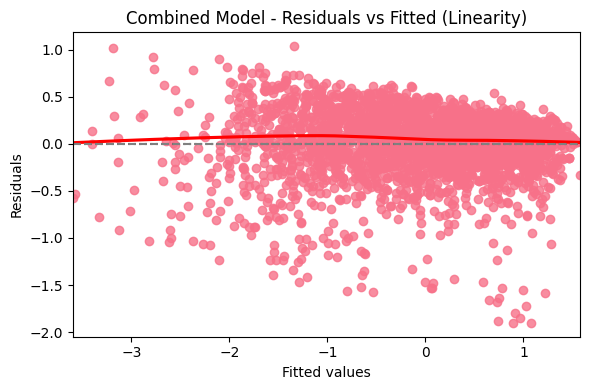


HOMOSCEDASTICITY (Breusch-Pagan):
  - LM stat = 167.065, p = 0.0000
  - F stat  = 3.345, p = 0.0000
  ⚠️ Heteroscedasticity detected (variance not constant)


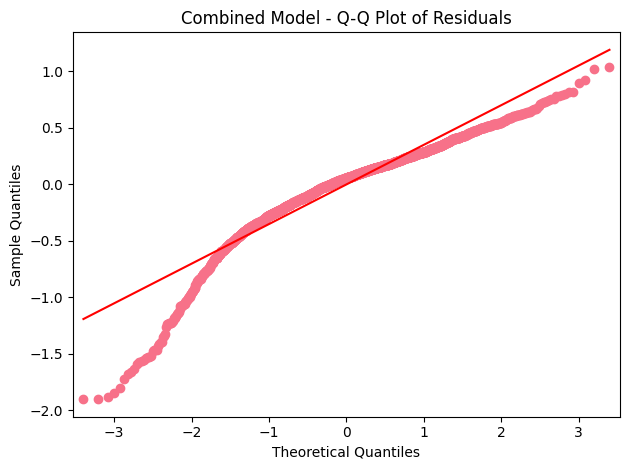


MULTICOLLINEARITY (Top 10 VIF):
                        Variable    VIF
0                          const  30.66
2     Emotional Likert.Lbal Sat    2.70
8   Emotional Likert.Lcont Imp     2.39
4     Emotional Likert.Lcnt Psy    2.39
5     Emotional Likert.Lcon Inc    2.32
13   Emotional Likert.Lres Ski     2.31
16  Functional Likert.Lcarprom D   2.25
14   Emotional Likert.Ltra Aut     2.25
3     Emotional Likert.Lcnt Com    2.17
9        Emotional Likert.Lgen     2.15


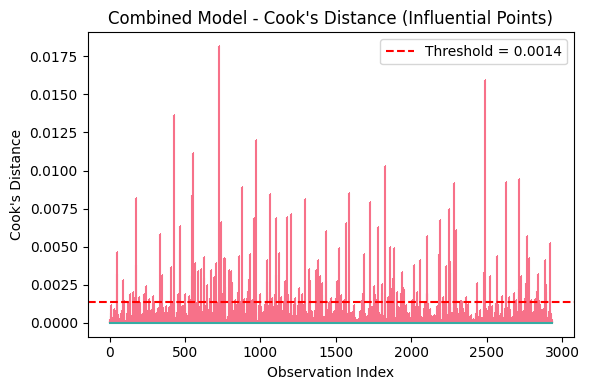


INFLUENTIAL POINTS (Cook's Distance):
  - 187 observations exceed threshold (4/n = 0.0014)


In [143]:
# Example: Run diagnostics for the 'combined' model
model_combined = results['combined']
X_train_combined = sm.add_constant(train_df[models_to_build['combined']])

run_regression_diagnostics(model_combined, X_train_combined, train_df['Preparedness levels'], model_name="Combined Model")

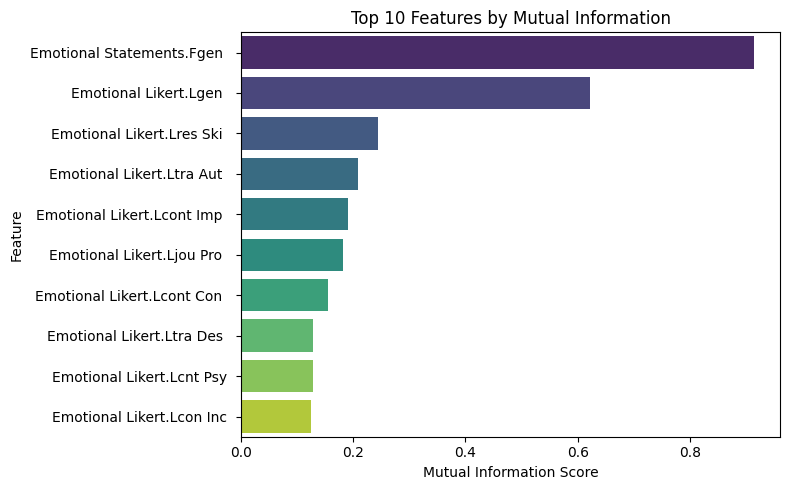

,Feature,Mutual_Info,F_stat,Pearson_corr,Spearman_corr
0,Emotional Statements.Fgen,0.914950,2103.771239,0.646284,0.636918
1,Emotional Likert.Lgen,0.621933,7410.533893,0.846429,0.848050
2,Emotional Likert.Lres Ski,0.243773,1372.266336,0.564572,0.600139
3,Emotional Likert.Ltra Aut,0.208012,1040.193097,0.511667,0.558577
4,Emotional Likert.Lcont Imp,0.189825,1084.269628,0.519521,0.568193
...,...,...,...,...,...
60,Functional Statements.Fexcess Wk,0.010320,4.989597,-0.041210,-0.054664
61,Functional Statements.Fmean Full,0.008640,76.381555,0.159315,0.124965
62,"Reserved, Quiet.",0.006572,3.127361,-0.032636,-0.011958
63,Functional Statements.Fenjhyb,0.004096,63.558412,0.145638,0.113152


In [144]:
all_features = list(chain.from_iterable(
        [y for x, y in feature_blocks.items() if x not in ['target', 'qualitative']]))

ranking_df = feature_informativeness(train_df[all_features], train_df['Preparedness levels'], top_n=10, plot=True)
ranking_df

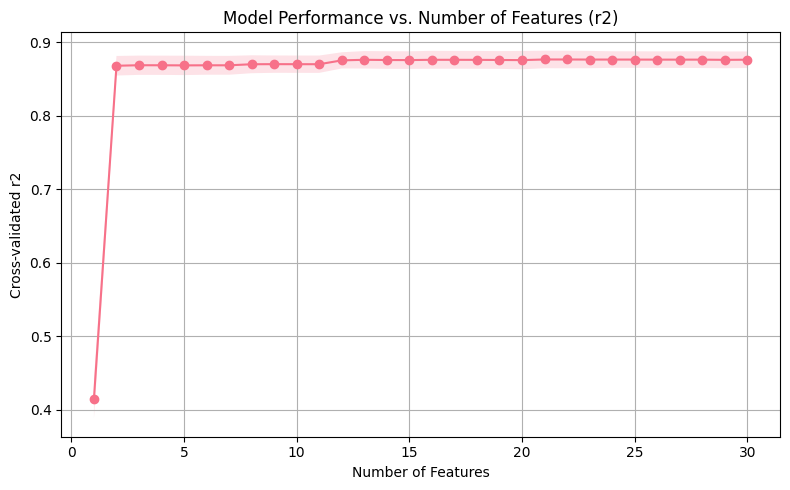


🏆 Best performance with 21 features: 0.876 ± 0.012
🧠 Top 21 most informative features used:
 1. Emotional Statements.Fgen  
 2. Emotional Likert.Lgen  
 3. Emotional Likert.Lres Ski  
 4. Emotional Likert.Ltra Aut  
 5. Emotional Likert.Lcont Imp  
 6. Emotional Likert.Ljou Pro  
 7. Emotional Likert.Lcont Con  
 8. Emotional Likert.Ltra Des  
 9. Emotional Likert.Lcnt Psy 
10. Emotional Likert.Lcon Inc 
11. Emotional Likert.Ljou Opt  
12. Open To New Experiences, Complex.
13. Functional Likert.Lcollea 
14. Dependable, Self-Disciplined.
15. Emotional Likert.Lbal Sat 
16. Functional Likert.Luse Skills 
17. Emotional Statements.Fjou Pro  
18. Emotional Likert.Lres Fin  
19. Emotional Likert.Lbal Anx 
20. Functional Likert.Lpoorman 
21. Sympathetic, Warm.


,Num_Features,Mean_Score,Std_Score,Test_R2
0,1,0.415018,0.026949,0.465489
1,2,0.867772,0.013312,0.866232
2,3,0.868482,0.013117,0.867490
3,4,0.868424,0.013093,0.867547
4,5,0.868275,0.013201,0.867634
5,6,0.868400,0.012842,0.868485
6,7,0.868390,0.012830,0.868337
7,8,0.869822,0.012182,0.870321
8,9,0.869950,0.011808,0.870237
9,10,0.869892,0.011797,0.870281


In [145]:
results_df, best_features = incremental_feature_selection(train_df[all_features], train_df['Preparedness levels'], ranking_df, model=RidgeCV(), scoring='r2', max_features=30)
results_df


🔍 Training Ridge...


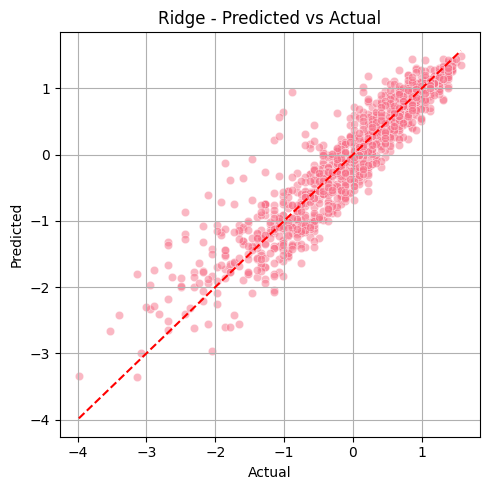

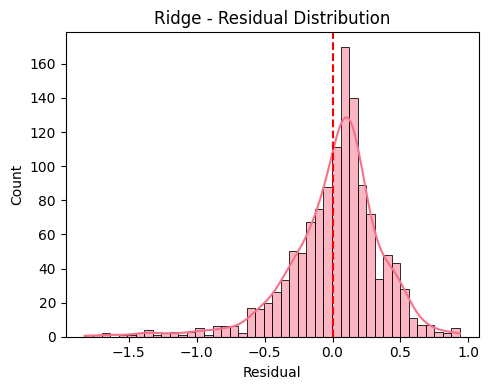


🔍 Training Lasso...


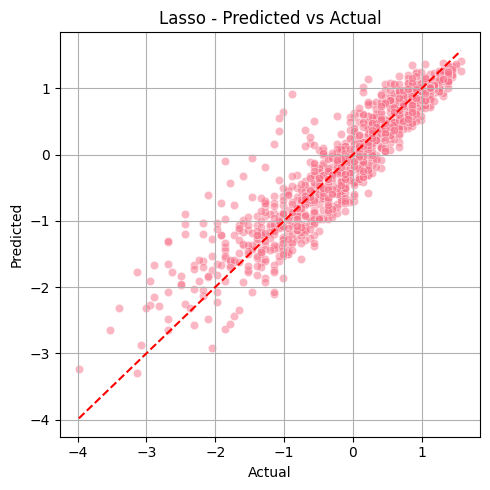

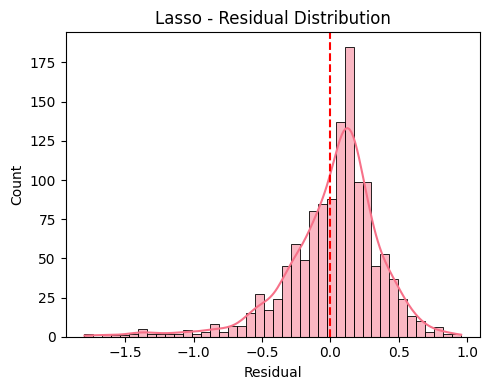


🔍 Training SVR...


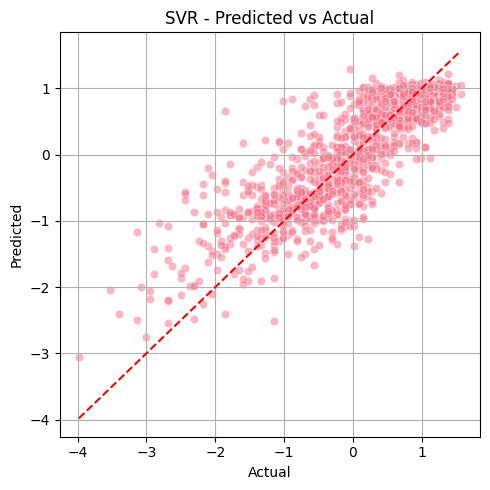

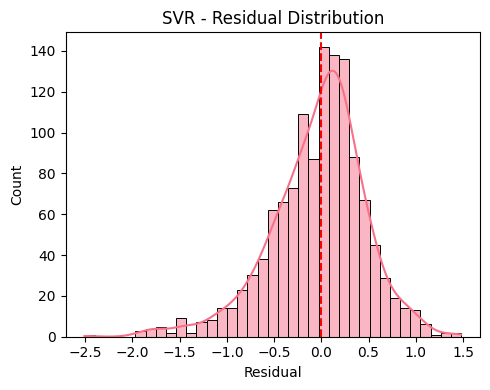


🔍 Training Random Forest...


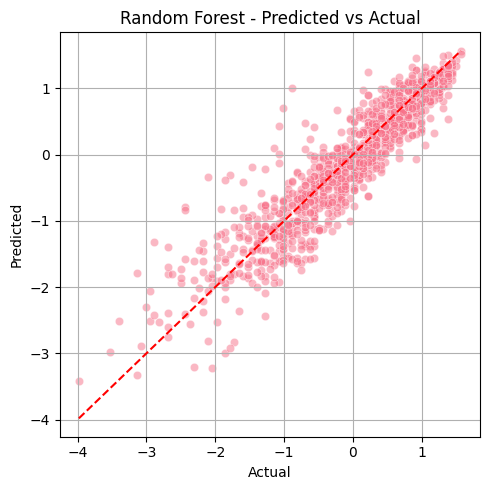

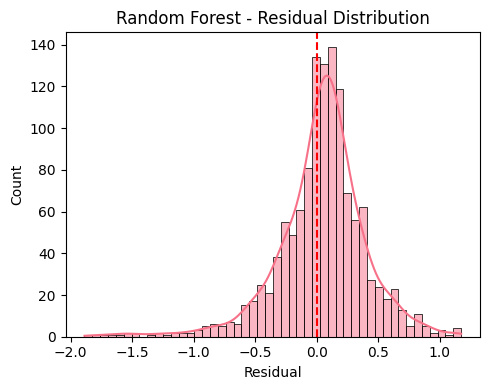


📊 Model Comparison:


,Model,cv_score,Test_R2,RMSE,MAE,Bias
0,Ridge,0.875481,0.875484,0.121419,0.251894,0.017231
1,Lasso,0.872976,0.872178,0.124642,0.257643,0.017709
3,Random Forest,0.856051,0.862081,0.134489,0.261684,0.040772
2,SVR,0.709134,0.736336,0.257105,0.379244,-0.037535


In [146]:
target_col = 'Preparedness levels'
results_df, models, preds, X_test = train_and_evaluate_models(train_df, test_df, target_col, best_features[:15])


🔎 SHAP Analysis for RidgeCV


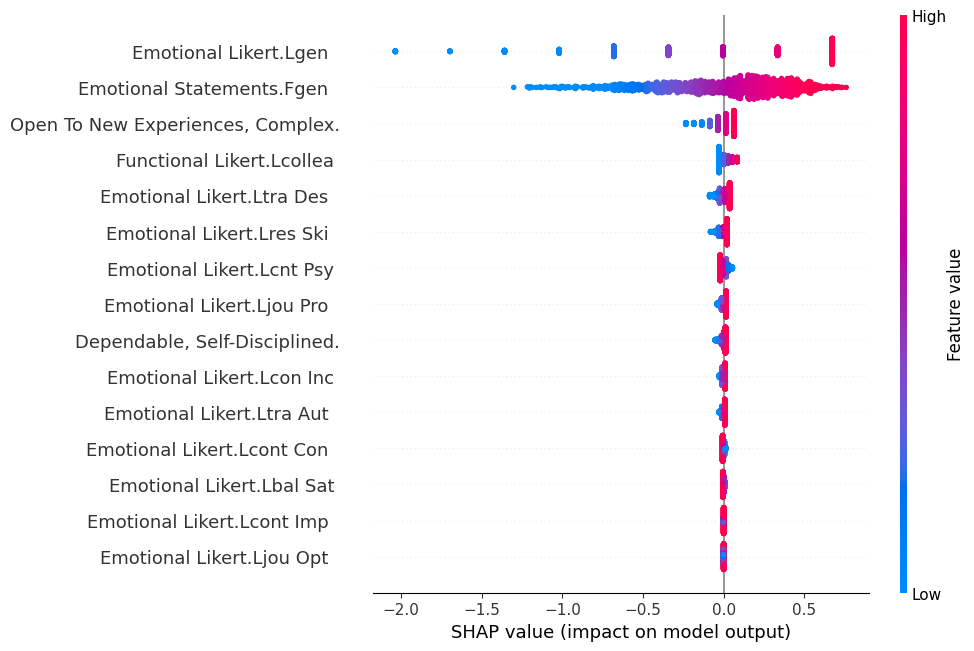

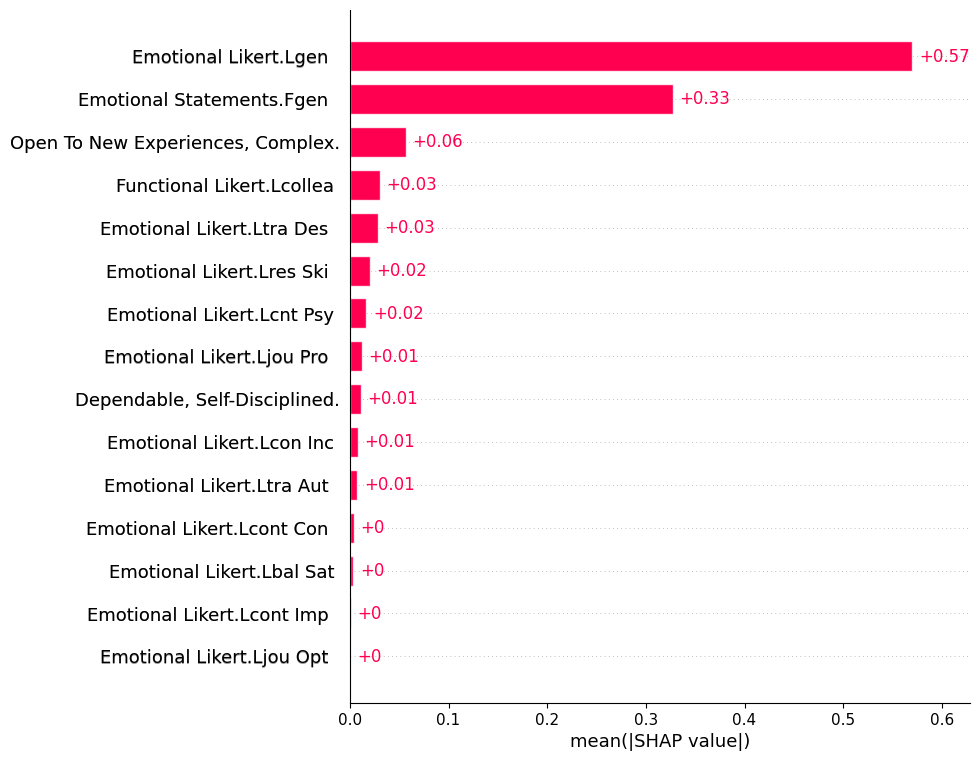

In [147]:
# SHAP for top model
top_model_name = results_df.iloc[0]['Model']
top_model = models[top_model_name]

shap_feature_importance(top_model, X_test, best_features[:15],
                        model_type='tree' if top_model_name == 'Random Forest' else 'linear')


🔎 SHAP Analysis for RandomForestRegressor


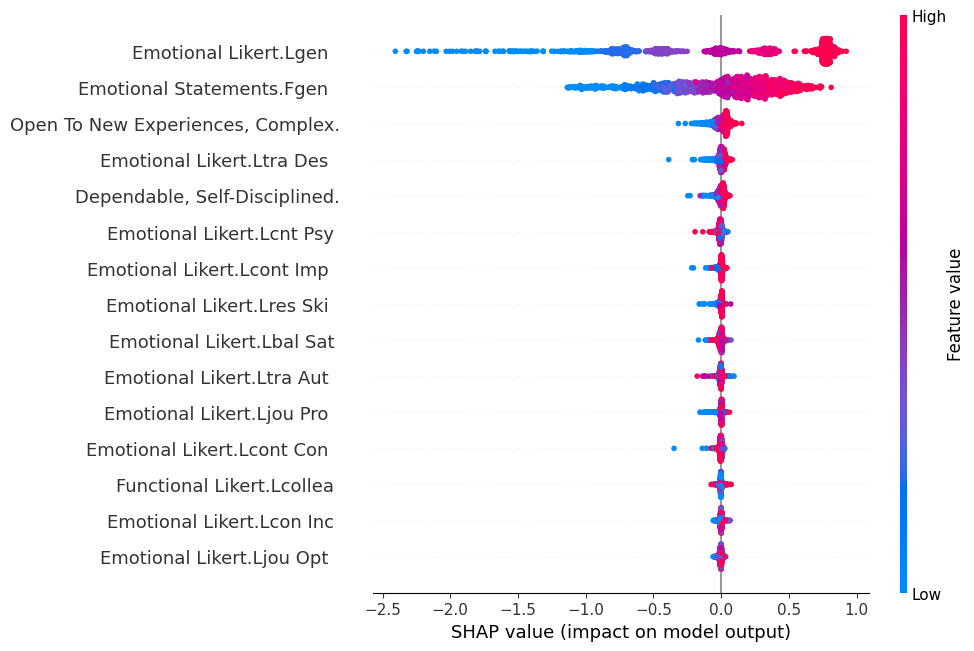

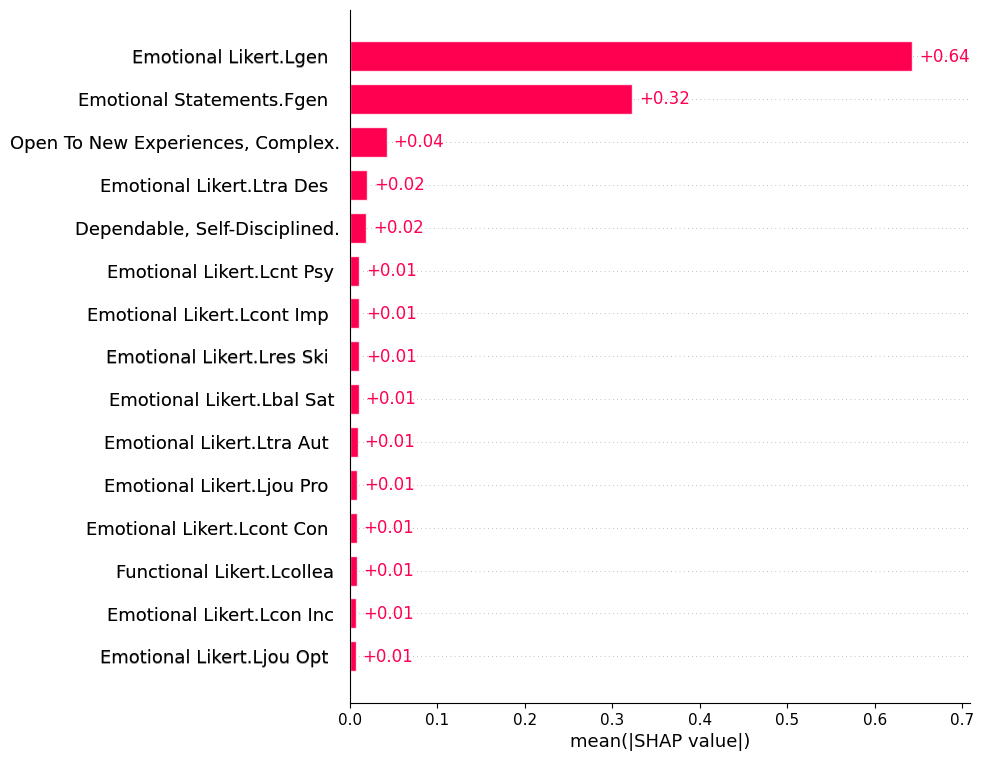

In [148]:
# SHAP for top model
top_model_name = results_df.iloc[2]['Model']
top_model = models[top_model_name]

shap_feature_importance(top_model, X_test, best_features[:15],
                        model_type='tree' if top_model_name == 'Random Forest' else 'linear')


In [149]:
results = enhanced_country_level_analysis(train_df, test_df, feature_blocks, all_features,
                                    target_col='Preparedness levels', country_col='Batch Group_encoded')


🌍 ENHANCED COUNTRY-LEVEL ANALYSIS
📍 Found 7 countries/regions: [4 2 0 1 5 3 6]

🔍 Feature Summary:
  - Selected features: 65
  - Explicit features: 26
  - Implicit features: 26

📊 PHASE 1: INDIVIDUAL COUNTRY MODELING
--------------------------------------------------

🏴 Country 4: 614 samples (Train: 442, Test: 172)
   ✅ Best Model: Ridge
   📊 Test R² = 0.845, CV = 0.872±0.021
   🎯 Top 3 Features: Emotional Statements.Fgen  , Emotional Statements.Fcnt Com  , Functional Statements.Fmean Full 

🏴 Country 2: 598 samples (Train: 421, Test: 177)
   ✅ Best Model: Ridge
   📊 Test R² = 0.878, CV = 0.876±0.029
   🎯 Top 3 Features: Emotional Statements.Fgen  , Functional Statements.Fwellcomp , Functional Statements.Fcarprom 

🏴 Country 0: 613 samples (Train: 428, Test: 185)
   ✅ Best Model: Ridge
   📊 Test R² = 0.818, CV = 0.836±0.014
   🎯 Top 3 Features: Emotional Statements.Fgen  , Sympathetic, Warm., Calm, Emotionally Stable.

🏴 Country 1: 592 samples (Train: 410, Test: 182)
   ✅ Best Model:

{'DE Fin': np.int64(0), 'FR Tech': np.int64(1), 'IT Fin': np.int64(2), 'SP Fin': np.int64(3), 'UK Energy': np.int64(4), 'US Pharma': np.int64(5), 'US Tech': np.int64(6)}


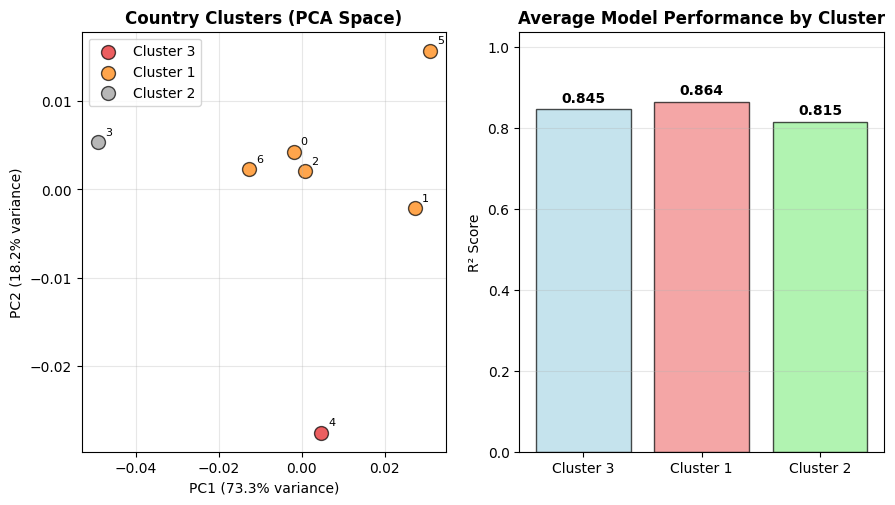

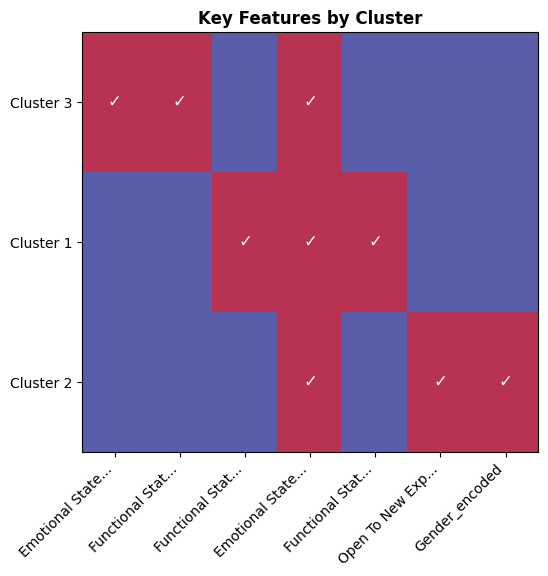

In [150]:
plot_country_clusters(results)
print(c_mapping)
c_heatmap(results, c_mapping)

In [151]:
# EXECUTE THIS:
segmentation_results = advanced_segmentation_analysis(df_scaled, feature_blocks)


👥 ADVANCED SEGMENTATION ANALYSIS
🎯 Using 62 features for clustering

🔍 K-MEANS CLUSTERING ANALYSIS:
  K=2: Silhouette Score = 0.234, Inertia = 169289057
  K=3: Silhouette Score = 0.137, Inertia = 157125783
  K=4: Silhouette Score = 0.125, Inertia = 149032841
  K=5: Silhouette Score = 0.121, Inertia = 142923390
  K=6: Silhouette Score = 0.102, Inertia = 137905578
  K=7: Silhouette Score = 0.094, Inertia = 134744744
🏆 Optimal K selected: 2 (highest silhouette score)

🔍 GAUSSIAN MIXTURE MODEL ANALYSIS:
  K=2: BIC = 1522659, AIC = 1497097
  K=3: BIC = 1528403, AIC = 1490056
  K=4: BIC = 1496950, AIC = 1445819
  K=5: BIC = 1509753, AIC = 1445838
  K=6: BIC = 1522322, AIC = 1445622
  K=7: BIC = 1536120, AIC = 1446637
🏆 Optimal K for GMM: 4 (lowest BIC)

📊 K-MEANS SEGMENT PROFILES:

🏷️  Segment 0:
   Size: 2283 (54.4%)
   Preparedness: 0.501 ± 0.720
   Top distinguishing features:
     Emotional Likert.Lcont Imp          | higher by 32.429
     Emotional Likert.Lcnt Psy           | higher by


👥 ADVANCED SEGMENTATION ANALYSIS
🎯 Using 62 features for clustering

🔍 K-MEANS CLUSTERING ANALYSIS:
  K=2: Silhouette Score = 0.234, Inertia = 169289057
  K=3: Silhouette Score = 0.137, Inertia = 157125783
  K=4: Silhouette Score = 0.125, Inertia = 149032841
  K=5: Silhouette Score = 0.121, Inertia = 142923390
  K=6: Silhouette Score = 0.102, Inertia = 137905578
  K=7: Silhouette Score = 0.094, Inertia = 134744744
🏆 Optimal K selected: 2 (highest silhouette score)

🔍 GAUSSIAN MIXTURE MODEL ANALYSIS:
  K=2: BIC = 1522659, AIC = 1497097
  K=3: BIC = 1528403, AIC = 1490056
  K=4: BIC = 1496950, AIC = 1445819
  K=5: BIC = 1509753, AIC = 1445838
  K=6: BIC = 1522322, AIC = 1445622
  K=7: BIC = 1536120, AIC = 1446637
🏆 Optimal K for GMM: 4 (lowest BIC)

📊 K-MEANS SEGMENT PROFILES:

🏷️  Segment 0:
   Size: 2283 (54.4%)
   Preparedness: 0.501 ± 0.720
   Top distinguishing features:
     Emotional Likert.Lcont Imp          | higher by 32.429
     Emotional Likert.Lcnt Psy           | higher by

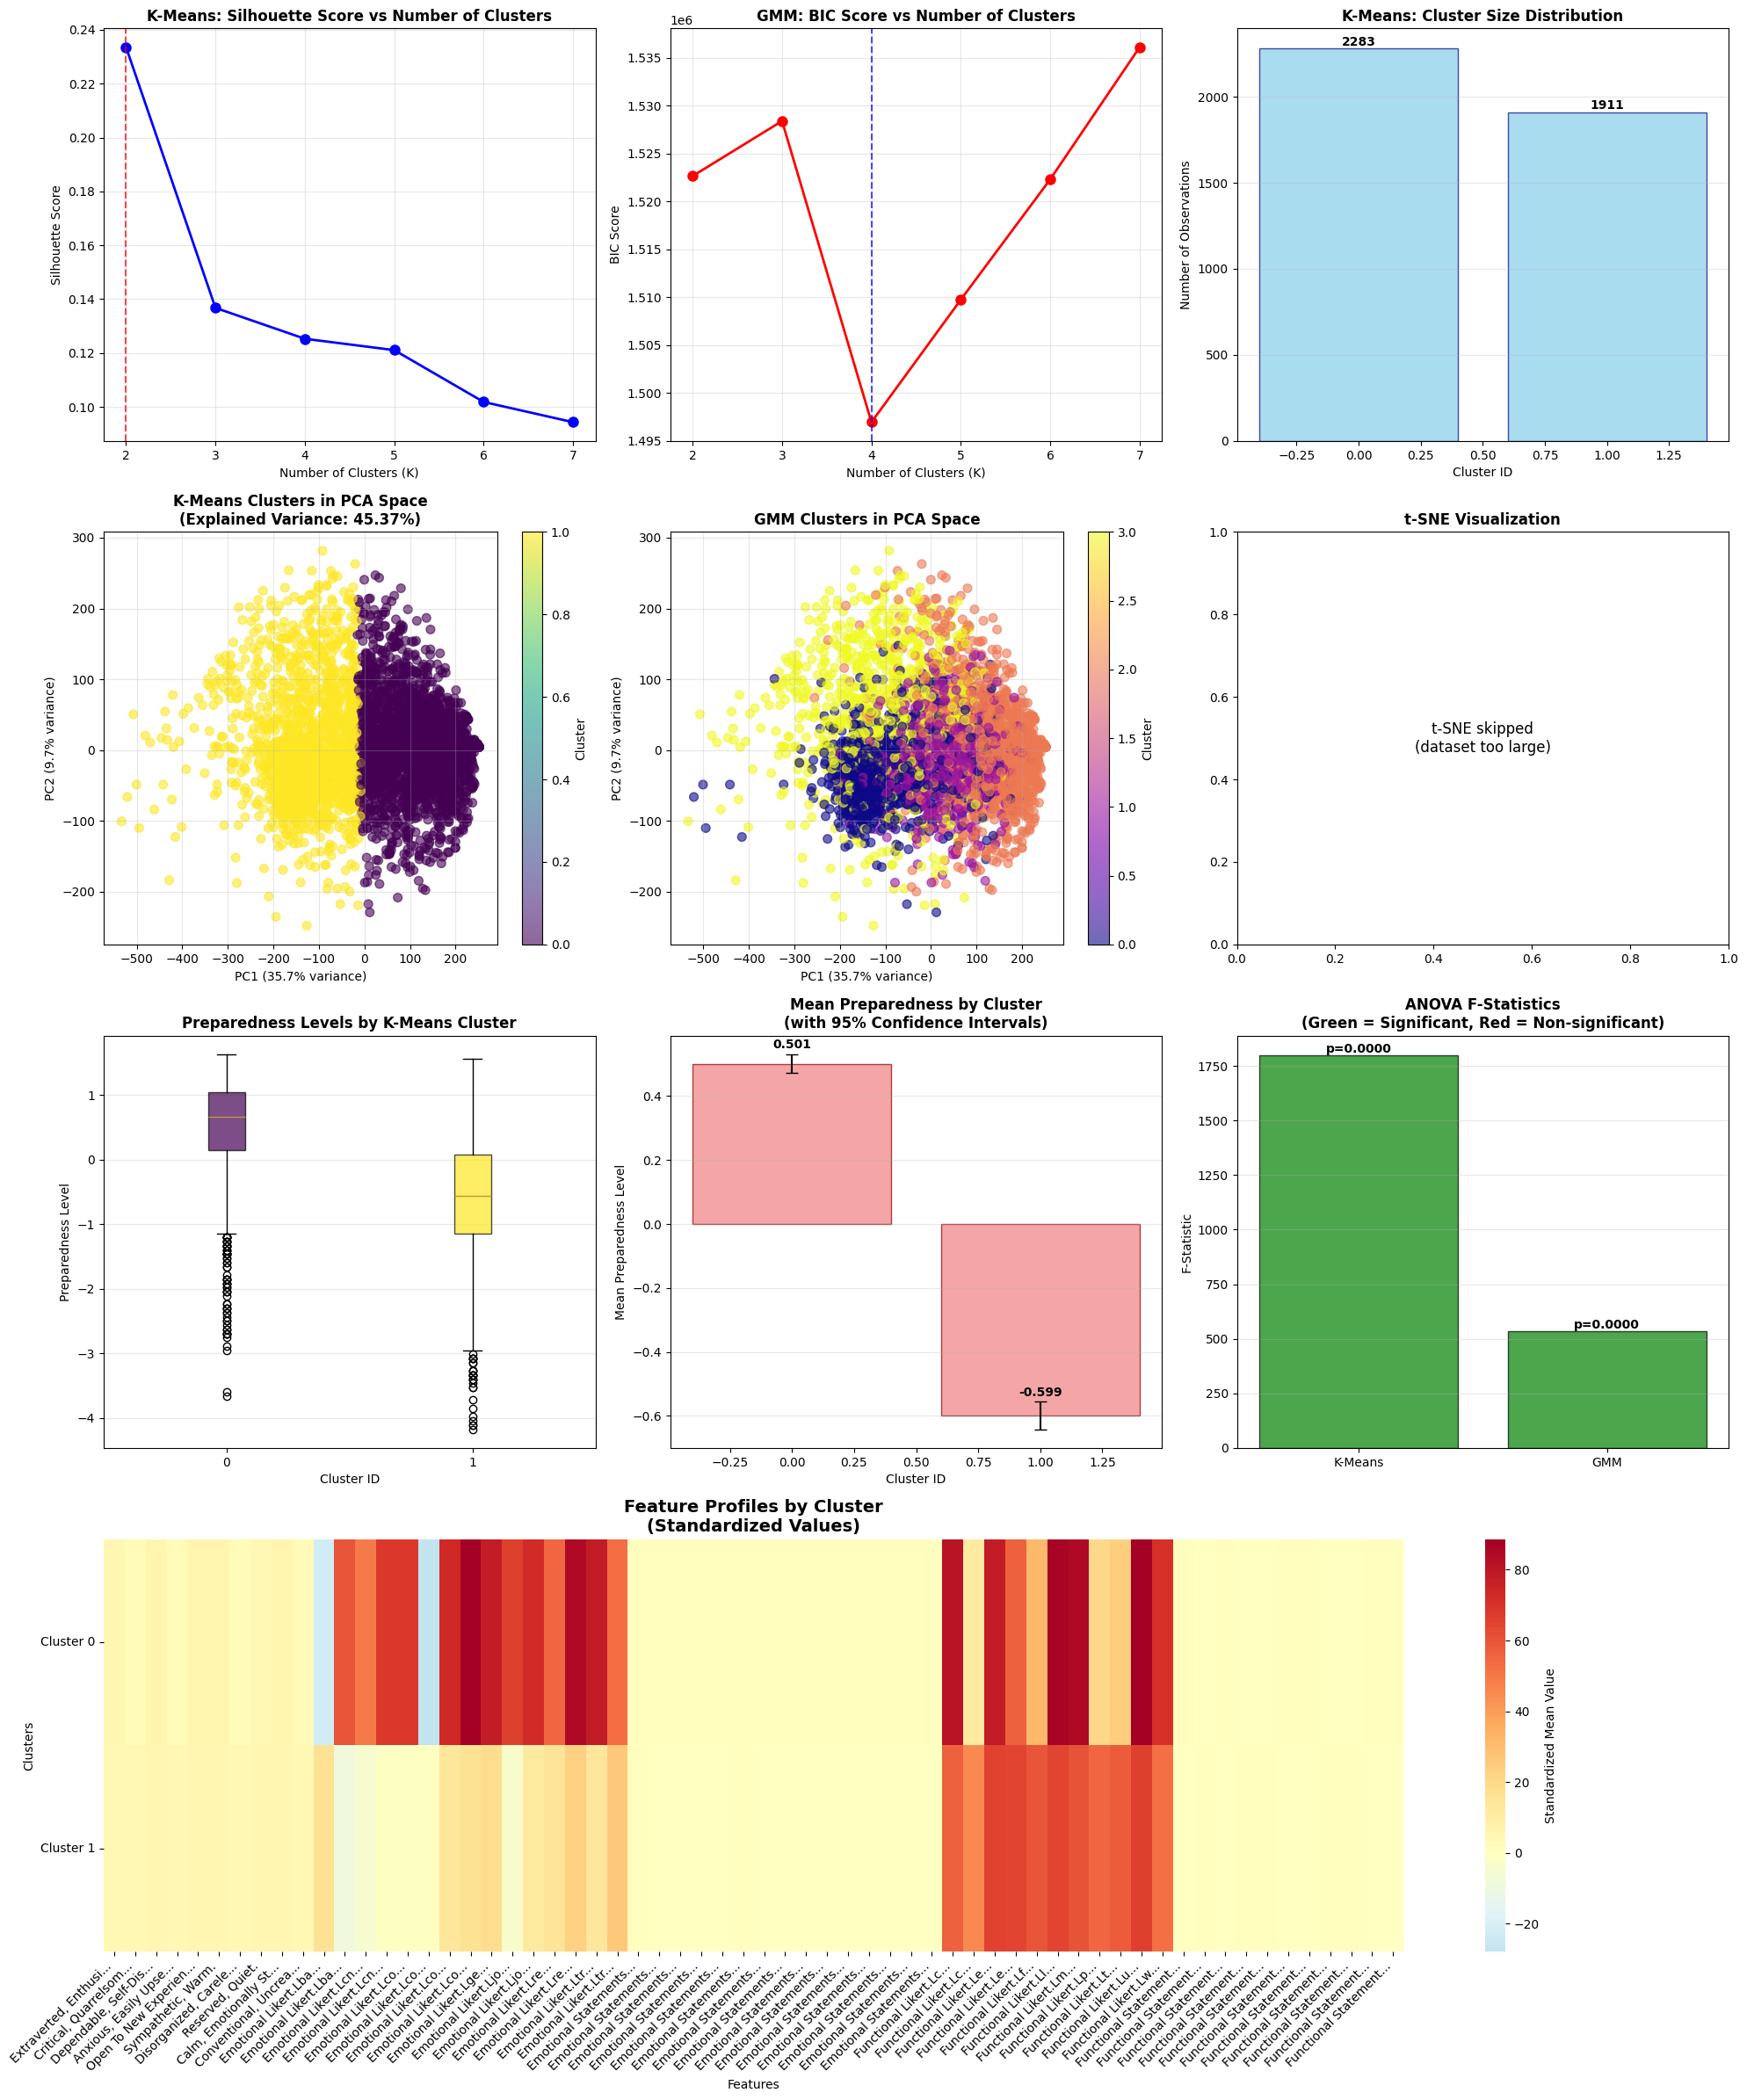


📊 SEGMENTATION ANALYSIS SUMMARY

🎯 OPTIMAL CLUSTER NUMBERS:
   K-Means: 2 clusters
   GMM:     4 clusters

🔍 CLUSTERING FEATURES:
   Total features used: 62
   Feature categories: ['demographics', 'personality_traits', 'explicit_emotional', 'implicit_emotional', 'explicit_workplace', 'implicit_workplace', 'target', 'qualitative']

📈 STATISTICAL VALIDATION:
   K-Means ANOVA: F=1799.170, p=0.0000
   GMM ANOVA:     F=536.043, p=0.0000
   K-Means: ✅ Significant
   GMM:     ✅ Significant

📋 DETAILED CLUSTER COMPARISON TABLE
  Cluster  Size Percentage Preparedness_Mean Preparedness_Std demographics_avg personality_traits_avg explicit_emotional_avg implicit_emotional_avg explicit_workplace_avg implicit_workplace_avg
Cluster 0  2283      54.4%             0.501            0.720            1.572                  4.569                 56.212                  0.245                 57.639                  0.056
Cluster 1  1911      45.6%            -0.599            0.958            1.451        

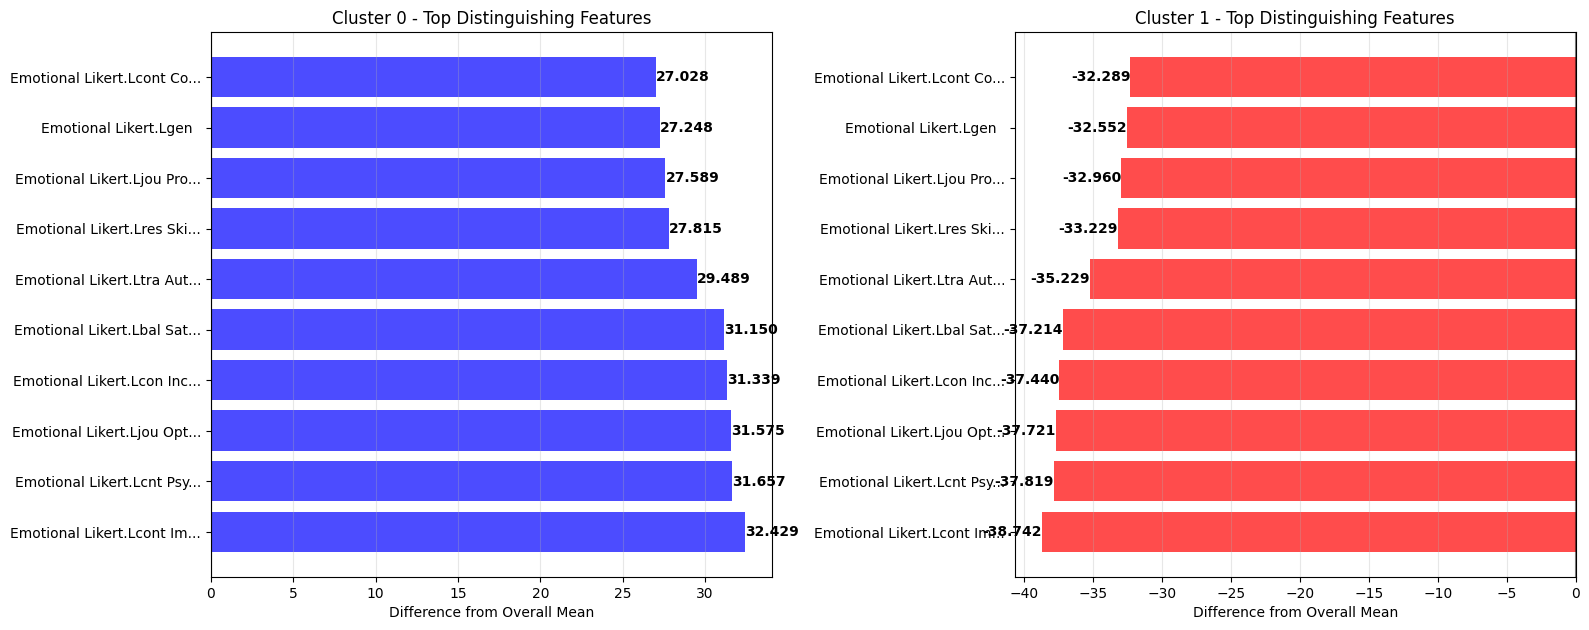


✅ VISUALIZATION COMPLETE!

Interpretation Guide:
📊 Use the cluster selection plots to validate optimal K
🗺️  Use PCA/t-SNE plots to see cluster separation
📈 Use preparedness plots to understand business impact
🔥 Use feature heatmaps to understand cluster profiles
🎯 Use feature importance plots to name/interpret clusters


In [152]:
# EXECUTE THIS INSTEAD OF THE ORIGINAL FUNCTION:
segmentation_results, viz_fig, comparison_table, feature_fig = advanced_segmentation_analysis_with_viz(df_scaled, feature_blocks)